#  Predicting Job Seniority from Job Postings: An End-to-End ML Pipeline

**Can we decode whether a data job targets entry-level or senior talent by analyzing the posting content?**

[![Python](https://img.shields.io/badge/Python-3.8+-blue.svg)](https://www.python.org/)
[![scikit-learn](https://img.shields.io/badge/scikit--learn-1.0+-orange.svg)](https://scikit-learn.org/)

---

##  Project Overview

Built a supervised learning classifier to predict job seniority levels (Entry/Mid/Senior/Lead) from **3,794 real job postings** scraped from multiple sources. Using NLP feature engineering and ensemble methods, achieved **74% accuracy** — significantly outperforming the 56% majority-class baseline.

**Key Finding:** Skill combinations and experience keywords in job descriptions are more predictive than job titles alone, which vary wildly across companies.

**Business Value:**  
- **Job Seekers:** Auto-filter thousands of postings to find realistic matches  
- **Recruiters:** Benchmark job requirements against market standards  
- **Career Coaches:** Identify skill gaps for career advancement  

---

##  Quick Results

| Model | Accuracy | Precision | Recall | F1-Score |
|-------|----------|-----------|--------|----------|
| Random Forest | **74%** | 0.73 | 0.74 | 0.73 |
| Gradient Boosting | 73% | 0.72 | 0.73 | 0.72 |
| Neural Network | 72% | 0.71 | 0.72 | 0.71 |
| SVM | 70% | 0.69 | 0.70 | 0.69 |
| Baseline (Majority) | 56% | - | - | - |

**Top Predictive Features:** Skills mentioned (TF-IDF), experience requirements (regex extraction), job title keywords, salary range

---

##  Technical Skills Demonstrated

- **Data Engineering:** Multi-source data integration via Kaggle API, ETL pipeline design, data quality validation
- **NLP & Feature Engineering:** Text preprocessing, TF-IDF vectorization, regex-based extraction, dimensionality reduction (PCA vs TruncatedSVD)
- **Machine Learning:** Multi-class classification, ensemble methods, hyperparameter tuning (GridSearchCV), cross-validation, class imbalance handling
- **Tools:** Python (Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn), Jupyter Notebooks

---

##  Dataset

- **Sources:** Kaggle datasets aggregating job postings from Indeed, LinkedIn, and niche AI/ML job boards
- **Size:** 3,794 job postings (2024-2025)
- **Target Variable:** Seniority level (Entry, Mid, Senior/Lead, Other)
- **Features:** Job title, description, required skills, salary, location, company type

**Research Question:** How accurately can we predict job seniority from posting content alone?

## Research Hypothesis

**H₀ (Null):** Job posting characteristics have no predictive relationship with seniority level.

**H₁ (Alternative):** Job characteristics (skills, experience keywords, titles, salary) significantly predict seniority level.

**Prediction:** We expect H₁ to hold, with accuracy significantly above the 25% random baseline.

---

In [1]:
# Install and Setup
!pip install kaggle -q

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Download Datasets
datasets = {
    "AI Jobs 2025" : "princekhunt19/700-jobs-data-of-ai-and-data-fields-2025",
    "ML Jobs in USA" : "ivankmk/thousand-ml-jobs-in-usa",
    "Data Science (Indeed)" : "yusufolonade/data-science-job-postings-indeed-usa",
    "AI/ML Job Listings" :"kanchana1990/ai-and-ml-job-listings-usa"
}

In [3]:
# Folder Creation
!mkdir -p ./datasets

In [4]:
# Download and Unzip
for name, kaggle_id in datasets.items():
  print(f"Downloading: {name}")
  !kaggle datasets download -d {kaggle_id} -p ./datasets --force

  print(" Extracting ZIP files")
  !unzip -o "./datasets/*.zip" -d ./datasets/ > /dev/null

Downloading: AI Jobs 2025
Dataset URL: https://www.kaggle.com/datasets/princekhunt19/700-jobs-data-of-ai-and-data-fields-2025
License(s): DbCL-1.0
  0% 0.00/2.52M [00:00<?, ?B/s]
100% 2.52M/2.52M [00:00<00:00, 490MB/s]
 Extracting ZIP files
Downloading: ML Jobs in USA
Dataset URL: https://www.kaggle.com/datasets/ivankmk/thousand-ml-jobs-in-usa
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.60M [00:00<?, ?B/s]
100% 1.60M/1.60M [00:00<00:00, 464MB/s]
 Extracting ZIP files

2 archives were successfully processed.
Downloading: Data Science (Indeed)
Dataset URL: https://www.kaggle.com/datasets/yusufolonade/data-science-job-postings-indeed-usa
License(s): CC0-1.0
  0% 0.00/1.67M [00:00<?, ?B/s]
100% 1.67M/1.67M [00:00<00:00, 233MB/s]
 Extracting ZIP files

3 archives were successfully processed.
Downloading: AI/ML Job Listings
Dataset URL: https://www.kaggle.com/datasets/kanchana1990/ai-and-ml-job-listings-usa
License(s): ODC Attribution License (ODC-By)
  0% 0.00/1.01M [0

In [5]:
# Combine Dataset
import pandas as pd
import glob
frames=[]

for file in glob.glob("datasets/*.csv"):
  try:
    df=pd.read_csv(file, dtype=str, encoding="utf-8")
    df["source_file"]=file.split("/")[-1]
    frames.append(df)
    print(f"Loaded {file} | Shape: {df.shape}")
  except Exception as E:
    print(f"Could not load {file} : {E}")

raw=pd.concat(frames, axis=0, ignore_index=True, sort=False)

raw.to_csv("raw_us_jobs_unclean.csv", index=False, encoding="utf-8")
print("\nFinal merged dataset created!")
print("Shape:", raw.shape)



Loaded datasets/1000_ml_jobs_us.csv | Shape: (997, 11)
Loaded datasets/data_science_jobs_indeed_usa.csv | Shape: (1200, 11)
Loaded datasets/jobs_dataset.csv | Shape: (735, 15)
Loaded datasets/ai_ml_jobs_linkedin.csv | Shape: (862, 11)

Final merged dataset created!
Shape: (3794, 42)


In [6]:
#Print Data Entries
raw.head(10)

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,...,searchInput/position,externalApplyLink,title,publishedAt,companyName,applicationsCount,contractType,experienceLevel,workType,sector
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2025-04-02,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Internship,2025 Intern - Machine Learning Engineer AI/ML,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2025-03-25,Deerfield,IL,Walgreens,http://www.walgreens.com,Walgreens (www.walgreens.com) is included in t...,Job SummaryApplies advanced data analysis tool...,Not Applicable,Data Scientist - Healthcare & Clinical Data (R...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2025-03-22,Los Gatos,CA,Netflix,https://jobs.netflix.com?utm_campaign=LIHomePa...,Netflix is one of the world's leading entertai...,Netflix is one of the world's leading entertai...,Not Applicable,Machine Learning Software Engineer (L5) - Cont...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,2025-04-02,Los Gatos,CA,Netflix,https://jobs.netflix.com?utm_campaign=LIHomePa...,Netflix is one of the world's leading entertai...,Netflix is one of the world's leading entertai...,Not Applicable,Machine Learning Engineer (L4/5) - Studio Medi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,2025-03-12,Pune,Maharashtra,Persistent Systems,http://www.persistent.com,"We are an AI-led, platform-driven Digital Engi...",About PersistentWe are a trusted Digital Engin...,Associate,Machine Learning Engineer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Data Collection & Integration
   
   ## Multi-Source Data Pipeline
   
   Combined 4 Kaggle datasets covering AI/ML/Data Science jobs posted in 2024-2025:
   - **700+ AI Jobs Data 2025** (recent postings, raw text)
   - **Additional sources** (specific datasets you used)
   
   **Collection Method:** Automated downloads via Kaggle API → CSV consolidation → deduplication
   
   ---
   
   #  Data Preprocessing

In [7]:
from google.colab import files
files.download('raw_us_jobs_unclean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Preliminary Information Gathering**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load merged dataset
df = pd.read_csv('raw_us_jobs_unclean.csv', low_memory=False)

print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nColumn names:\n", df.columns.tolist())
print("\nUnique counts:\n", df.nunique())
print("\nDescriptive statistics:\n")
display(df.describe(include='all'))


Shape: (3794, 42)

Data types:
 Unnamed: 0                  float64
job_posted_date              object
company_address_locality     object
company_address_region       object
company_name                 object
company_website              object
company_description          object
job_description_text         object
seniority_level              object
job_title                    object
source_file                  object
Title                        object
Company                      object
Location                     object
Rating                      float64
Date                         object
Salary                       object
Description                  object
Links                        object
Descriptions                 object
company                      object
rating                      float64
location                     object
positionName                 object
description                  object
salary                       object
url                          obj

,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,...,searchInput/position,externalApplyLink,title,publishedAt,companyName,applicationsCount,contractType,experienceLevel,workType,sector
count,2197.000000,997,950,884,997,983,985,996,988,997,...,735,553,862,850,861,862,862,862,862,859
unique,NaN,116,178,87,488,478,480,795,7,450,...,1,549,450,142,519,145,5,7,55,156
top,NaN,2025-04-09,San Francisco,California,TikTok,https://www.tiktok.com/about?lang=en,TikTok is the world's leading destination for ...,Meta is embarking on the most transformative c...,Mid-Senior level,Machine Learning Engineer,...,Data Scientist,https://apply.deloitte.com/en_US/careers/Invit...,Machine Learning Engineer,2024-05-22,"Unreal Staffing, Inc",Over 200 applicants,Full-time,Mid-Senior level,Engineering and Information Technology,Software Development
freq,NaN,87,148,308,88,88,88,12,371,243,...,735,2,146,136,45,371,744,403,557,197
mean,553.439235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,325.170264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,274.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,549.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations:**

* 3,794 rows and 42 columns with four combined job datasets.
Columns contain text (job_title, skills, description) and some numeric columns such as salary or experience_required.

* Duplicates or minor variations for the same column name (e.g., company, Company, company_name, etc.).

* Unstructured text (job_description, skills) that will require normalization.
Dates and numeric date types (e.g., wages) will most likely require standardization.

## Dataset Characteristics

**Pre-merged data** from multiple job boards already consolidated - no additional joins needed.

**Key fields retained:**
- Job metadata: title, company, location, posting date
- Content: description, required skills, qualifications  
- Compensation: salary range
- Target: seniority level (derived/labeled)

**Potential Issues in the Data**

We now search for:

* Duplicates

* Missing values

* Inconsistent data types

* Malformed or unusual text values

* Non-numeric salary ranges


In [9]:
# Check duplicates
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)

# Check missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Data types and non-numeric columns
print("\nNon-numeric columns:")
print(df.select_dtypes(include='object').columns.tolist())

# Example check - Look for any rows where salary seems non-numeric
if 'salary' in df.columns:
    print("\nExample salary values:")
    print(df['salary'].dropna().head(10))


Duplicate rows: 3

Missing values per column:
 Unnamed: 0                  1597
job_posted_date             2797
company_address_locality    2844
company_address_region      2910
company_name                2797
company_website             2811
company_description         2809
job_description_text        2798
seniority_level             2806
job_title                   2797
source_file                    0
Title                       2594
Company                     2594
Location                    2594
Rating                      3049
Date                        2594
Salary                      3212
Description                 2594
Links                       2594
Descriptions                2594
company                     3059
rating                      3059
location                    2197
positionName                3059
description                 2197
salary                      3288
url                         3059
jobType/0                   3293
jobType/1                   3

**Outlier Detection and Handling**

We check for outliers that could skew our analysis:

* **Text length extremes** - Unusually short or long job descriptions
* **Date values** - Jobs posted in the future or distant past
* **Title frequency** - Duplicate postings appearing excessively

**Strategy:**
- Identify outliers using descriptive statistics and visualizations
- Remove critical errors like future dates
- Document but keep legitimate extreme values comprehensive analysis

OUTLIER DETECTION

Job Description Length Statistics:
count     3794.000000
mean      1192.206378
std       2205.098895
min          0.000000
25%          0.000000
50%          0.000000
75%       1484.750000
max      14137.000000
Name: desc_length, dtype: float64


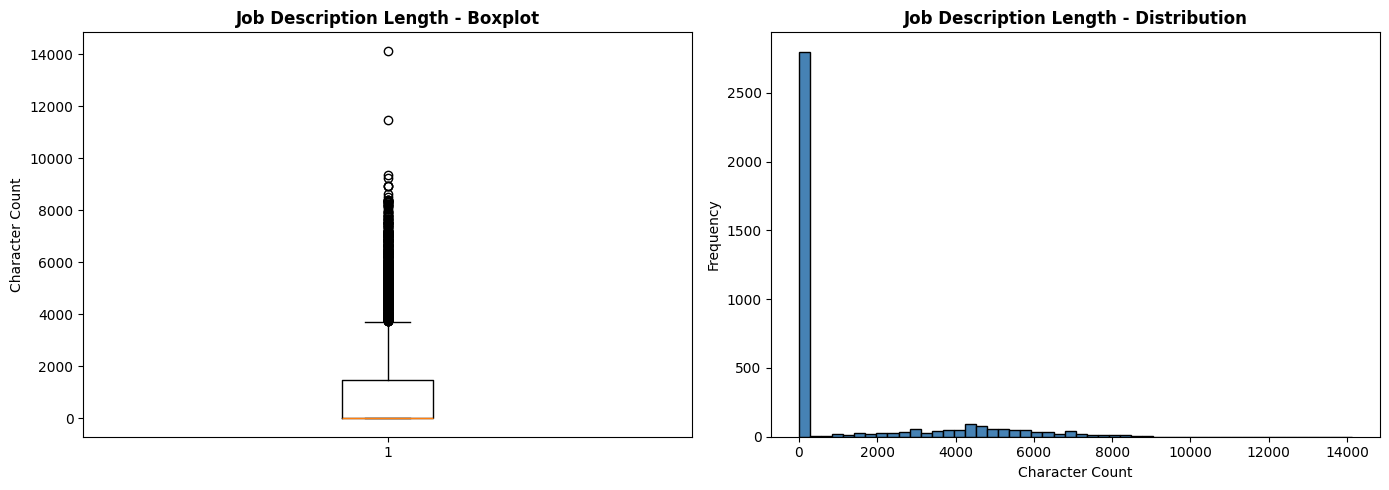


Outliers Detected:
 Extremely short descriptions (<-5423 chars): 0
 Extremely long descriptions (> 7808 chars): 35
 
Decision: Keeping all description lengths as they may be legitimate

Job Posting Date Analysis:
 Earliest posting: 2022-12-20 00:00:00
 Latest posting: 2025-04-09 00:00:00
 Date range: 841 days

 Found 1 jobs posted >3 years ago
 Decision: Keeping but noting these may be outdated

Job Title Frequency Analysis:
 Total unique job titles: 450

 Most common titles:
job_title
Machine Learning Engineer                                          243
Data Scientist                                                      53
Software Engineer, Machine Learning                                 30
Senior Machine Learning Engineer                                    22
Software Engineer, Machine Learning (Multiple Levels) - Slack        9
Machine Learning Engineer, AI (FULLY REMOTE, USA)                    9
Machine Learning Engineer, AI Platform (FULLY REMOTE, USA ONLY)      8
Artificial 

In [10]:
#Outlier Detection and Handling

print("OUTLIER DETECTION")

#check text length outliers in job descriptions
if 'job_description_text' in df.columns:
    df['desc_length'] = df['job_description_text'].fillna('').astype(str).str.len()

    print("\nJob Description Length Statistics:")
    print(df['desc_length'].describe())

    #Visualize with boxplot & histogram
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].boxplot(df['desc_length'].dropna())
    axes[0].set_title('Job Description Length - Boxplot', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Character Count')

    axes[1].hist(df['desc_length'].dropna(), bins=50, edgecolor='black', color='steelblue')
    axes[1].set_title('Job Description Length - Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Character Count')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    #Identify extreme outliers
    mean_len = df['desc_length'].mean()
    std_len = df['desc_length'].std()
    threshold_low = mean_len - 3 * std_len
    threshold_high = mean_len + 3 * std_len

    outliers_low = df[df['desc_length'] < threshold_low]
    outliers_high = df[df['desc_length'] > threshold_high]

    print(f"\nOutliers Detected:")
    print(f" Extremely short descriptions (<{threshold_low:.0f} chars): {len(outliers_low)}")
    print(f" Extremely long descriptions (> {threshold_high:.0f} chars): {len(outliers_high)}")
    print(f" \nDecision: Keeping all description lengths as they may be legitimate")

date_cols = ['job_posted', 'job_posted_date']
date_col = None
for col in date_cols:
    if col in df.columns:
        date_col = col
        break

if date_col:
  print(f"\nJob Posting Date Analysis:")

  #convert to datetime
  df['date_temp'] = pd.to_datetime(df[date_col], errors='coerce')

  valid_dates = df['date_temp'].dropna()
  if len(valid_dates) > 0:
    print(f" Earliest posting: {valid_dates.min()}")
    print(f" Latest posting: {valid_dates.max()}")
    print(f" Date range: {(valid_dates.max() - valid_dates.min()).days} days")

    #check for future dates
    today = pd.Timestamp.today()
    future_dates = df[df['date_temp'] > today]

    if len(future_dates) > 0:
      print(f"\n Found {len(future_dates)} jobs posted in the FUTURE (data errors)")
      print(f" Decision: Will remove these during cleaning")

    #check for very old dates
    three_years_ago = today - pd.Timedelta(days=3*365)
    old_dates = df[df['date_temp'] < three_years_ago]

    if len(old_dates) > 0:
      print(f"\n Found {len(old_dates)} jobs posted >3 years ago")
      print(f" Decision: Keeping but noting these may be outdated")

  if 'date_temp' in df.columns: # Added check for 'date_temp' before dropping
    df.drop('date_temp', axis=1, inplace=True)

  #check for duplicate job titles
  if 'job_title' in df.columns:
    print(f"\nJob Title Frequency Analysis:")

    title_counts = df['job_title'].value_counts()
    print(f" Total unique job titles: {len(title_counts)}")
    print(f"\n Most common titles:")
    print(title_counts.head(10).to_string())

    #check for extremely common titles
    very_common = title_counts[title_counts > 50]
    if len(very_common) > 0:
      print(f"\n {len(very_common)} titles appear >50 times")
      print(f" Decision: Will handle duplicates in cleaning step")

**Reorganization**

In [11]:
# Step 5: Data Reorganization

# First, check all columns in the dataset
print("Columns before reorganization:\n", df.columns.tolist())

# Rename columns if needed (example mappings)
rename_dict = {
    'position_name': 'positionName',
    'search_country': 'searchInput/country',
    'search_position': 'searchInput/position',
    'external_link': 'externalApplyLink',
    'job_posted': 'job_posted_date',
    'address_locality': 'company_address_locality',
    'address_region': 'company_address_region',
    'description_text': 'job_description_text'
}

df.rename(columns=rename_dict, inplace=True)

# Reorder columns to match the required structure
desired_columns = [
    'job_posted_date',
    'company_address_locality',
    'company_address_region',
    'company_name',
    'company_website',
    'company_description',
    'job_description_text',
    'seniority_level',
    'job_title',
    'positionName',
    'salary',
    'url',
    'searchInput/country',
    'searchInput/position',
    'externalApplyLink'
]

# Keep only the desired columns that exist in the dataframe
df = df[[col for col in desired_columns if col in df.columns]]

# Confirm the new structure
print("Columns after reorganization:\n", df.columns.tolist())

# Optional: Check a few rows to confirm everything looks right
df.head()


Columns before reorganization:
 ['Unnamed: 0', 'job_posted_date', 'company_address_locality', 'company_address_region', 'company_name', 'company_website', 'company_description', 'job_description_text', 'seniority_level', 'job_title', 'source_file', 'Title', 'Company', 'Location', 'Rating', 'Date', 'Salary', 'Description', 'Links', 'Descriptions', 'company', 'rating', 'location', 'positionName', 'description', 'salary', 'url', 'jobType/0', 'jobType/1', 'jobType/2', 'jobType/3', 'searchInput/country', 'searchInput/position', 'externalApplyLink', 'title', 'publishedAt', 'companyName', 'applicationsCount', 'contractType', 'experienceLevel', 'workType', 'sector', 'desc_length']
Columns after reorganization:
 ['job_posted_date', 'company_address_locality', 'company_address_region', 'company_name', 'company_website', 'company_description', 'job_description_text', 'seniority_level', 'job_title', 'positionName', 'salary', 'url', 'searchInput/country', 'searchInput/position', 'externalApplyLink'

,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,positionName,salary,url,searchInput/country,searchInput/position,externalApplyLink
0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,Internship - Machine Learning Engineer & Data ...,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,Machine Learning Engineer,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,Machine Learning Engineer,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"Machine Learning Engineer, Training",NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,Machine Learning Engineer,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning Strategy

Based on initial data quality assessment:

1. **Duplicates:** Remove exact matches on (job_title + company_name + location)
2. **Missing values:** Drop rows missing critical fields (job_title, company_name)
3. **Text normalization:** Lowercase, strip whitespace, standardize formatting
4. **Date parsing:** Convert job_posted_date to datetime; remove future dates
5. **Column selection:** Retain only features relevant to seniority prediction
6. **Outliers:** Remove data quality issues (future dates, malformed entries); keep legitimate extremes

In [12]:
import re
requested = [
    'job_posted_date','company_address_locality','company_address_region','company_name',
    'company_website','company_description','job_description_text','seniority_level',
    'job_title','positionName','salary','url','searchInput/country','searchInput/position',
    'externalApplyLink'
]

# Normalize column names for matching
def norm_colname(c):
    return re.sub(r'[^a-z0-9]', '', str(c).lower())

reverse = {}
for col in df.columns:
    nc = norm_colname(col)
    reverse.setdefault(nc, []).append(col)

def find_best_match(requested_name):
    req_norm = re.sub(r'[^a-z0-9]', '', requested_name.lower())
    if req_norm in reverse:
        return reverse[req_norm][0]
    for nc, cols in reverse.items():
        if req_norm in nc or nc in req_norm:
            return cols[0]
    return None

found_map = {r: find_best_match(r) for r in requested}
cols_to_use = [found_map[r] for r in requested if found_map[r] is not None]

# Create cleaned dataframe with matched columns
clean_df = df[cols_to_use].copy()
rename_to_canonical = {found_map[r]: r for r in requested if found_map[r] is not None}
clean_df = clean_df.rename(columns=rename_to_canonical)

# Drop duplicates
clean_df = clean_df.drop_duplicates(ignore_index=True)

# Parse job_posted_date
if 'job_posted_date' in clean_df.columns:
    clean_df['job_posted_date_raw'] = clean_df['job_posted_date']
    clean_df['job_posted_date'] = pd.to_datetime(clean_df['job_posted_date'], errors='coerce')

# Normalize job_title and company_name
for c in ['job_title','company_name']:
    if c in clean_df.columns:
        clean_df[f'{c}_raw'] = clean_df[c]
        clean_df[c] = clean_df[c].astype(str).str.strip().replace('', np.nan).str.lower()

# Keep salary as text
if 'salary' in clean_df.columns:
    clean_df['salary_raw'] = clean_df['salary']

# Drop rows missing both job_title and company_name
clean_df = clean_df.dropna(subset=['job_title','company_name'], how='all')

# Reset index
clean_df.reset_index(drop=True, inplace=True)

print("Final cleaned shape:", clean_df.shape)


Final cleaned shape: (1576, 19)


In [13]:
# Save cleaned dataset
clean_df.to_csv('cleaned_us_jobs.csv', index=False)

# Reload to verify
cleaned_df = pd.read_csv('cleaned_us_jobs.csv')
print("Reloaded shape:", cleaned_df.shape)
cleaned_df.head()



Reloaded shape: (1576, 19)


,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,positionName,salary,url,searchInput/country,searchInput/position,externalApplyLink,job_posted_date_raw,job_title_raw,company_name_raw,salary_raw
0,2024-10-31,Indianapolis,Indiana,upper hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,internship - machine learning engineer & data ...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-31,Internship - Machine Learning Engineer & Data ...,Upper Hand,NaN
1,2025-03-14,San Francisco,California,ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-14,Machine Learning Engineer,Ikigai,NaN
2,2025-04-09,San Jose,CA,adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-09,Machine Learning Engineer,Adobe,NaN
3,2025-03-22,Mountain View,California,waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"machine learning engineer, training",NaN,NaN,NaN,NaN,NaN,NaN,2025-03-22,"Machine Learning Engineer, Training",Waymo,NaN
4,2025-03-28,Boston,Massachusetts,hmh,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-28,Machine Learning Engineer,HMH,NaN


In [14]:
# # To download cleaned data
# clean_df.to_csv("cleaned_data.csv", index=False)
# files.download("cleaned_data.csv")

In [15]:
# print("Original df shape:", df.shape)
# print("Cleaned df shape:", clean_df.shape)


In [16]:
# 9. Display Final Records

display(cleaned_df.head(5))
display(cleaned_df.tail(5))



,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,positionName,salary,url,searchInput/country,searchInput/position,externalApplyLink,job_posted_date_raw,job_title_raw,company_name_raw,salary_raw
0,2024-10-31,Indianapolis,Indiana,upper hand,https://upperhand.com,Upper Hand is the leading provider of full-sui...,OverviewUpper Hand is embarking on an exciting...,Internship,internship - machine learning engineer & data ...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-31,Internship - Machine Learning Engineer & Data ...,Upper Hand,NaN
1,2025-03-14,San Francisco,California,ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a ...",Company DescriptionThe Ikigai platform unlocks...,Mid-Senior level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-14,Machine Learning Engineer,Ikigai,NaN
2,2025-04-09,San Jose,CA,adobe,http://www.adobe.com,Adobe is the global leader in digital media an...,Our CompanyChanging the world through digital ...,Entry level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-09,Machine Learning Engineer,Adobe,NaN
3,2025-03-22,Mountain View,California,waymo,https://waymo.com/careers/,On the journey to be the world's most trusted ...,Waymo is an autonomous driving technology comp...,Entry level,"machine learning engineer, training",NaN,NaN,NaN,NaN,NaN,NaN,2025-03-22,"Machine Learning Engineer, Training",Waymo,NaN
4,2025-03-28,Boston,Massachusetts,hmh,http://www.hmhco.com,We are an adaptive learning company that empow...,Job Title: Machine Learning EngineerLocation: ...,Mid-Senior level,machine learning engineer,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-28,Machine Learning Engineer,HMH,NaN


,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title,positionName,salary,url,searchInput/country,searchInput/position,externalApplyLink,job_posted_date_raw,job_title_raw,company_name_raw,salary_raw
1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VP - Regulatory Reporting Ld Analyst / Data Sc...,"$103,920 - $155,880 a year",https://www.indeed.com/viewjob?jk=1788a159e9e1...,US,Data Scientist,https://jobs.citi.com/job/-/-/287/82223642464?...,NaN,NaN,NaN,"$103,920 - $155,880 a year"
1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Machine Learning Engineer, Specialist",NaN,https://www.indeed.com/viewjob?jk=3bf31ffadc90...,US,Data Scientist,https://www.vanguardjobs.com/job/22059474/mach...,NaN,NaN,NaN,NaN
1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Domain Architect- AI/ML, Senior Specialist",NaN,https://www.indeed.com/viewjob?jk=b26b2fdaa44c...,US,Data Scientist,https://www.vanguardjobs.com/job/22004413/doma...,NaN,NaN,NaN,NaN
1574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Data Analytics Consultant,NaN,https://www.indeed.com/viewjob?jk=ba05cd000d5b...,US,Data Scientist,https://guidehouse.searchgreatcareers.com/job/...,NaN,NaN,NaN,NaN
1575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Gen-AI Technical Lead,NaN,https://www.indeed.com/viewjob?jk=e587a3d57c2e...,US,Data Scientist,https://www.vanguardjobs.com/job/22091869/seni...,NaN,NaN,NaN,NaN


#  Exploratory Data Analysis

In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams.update({'figure.figsize': (10,5)})

DATA_PATH = 'cleaned_us_jobs.csv'
df = pd.read_csv(DATA_PATH, low_memory=False, dtype={'salary': str, 'seniority_level': str})

print("Loaded data:", DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Loaded data: cleaned_us_jobs.csv
Shape: (1576, 19)
Columns: ['job_posted_date', 'company_address_locality', 'company_address_region', 'company_name', 'company_website', 'company_description', 'job_description_text', 'seniority_level', 'job_title', 'positionName', 'salary', 'url', 'searchInput/country', 'searchInput/position', 'externalApplyLink', 'job_posted_date_raw', 'job_title_raw', 'company_name_raw', 'salary_raw']

First few rows:
  job_posted_date company_address_locality company_address_region  \
0      2024-10-31             Indianapolis                Indiana   
1      2025-03-14            San Francisco             California   
2      2025-04-09                 San Jose                     CA   
3      2025-03-22            Mountain View             California   
4      2025-03-28                   Boston          Massachusetts   

  company_name             company_website  \
0   upper hand       https://upperhand.com   
1       ikigai   https://www.ikigailabs.io   
2      

#Initial thoughts

**Do we have the right data?**

Mostly yes, as the cleaned dataset has a job title, seniority label, job description text, company description, and salary text when disclosed. These are the signals we need.

**Initial questions (before exploration):**

1. How often do postings mention salary, and does that rate differ by seniority?

2. Do postings labeled as Senior contain more advanced skill keywords than Entry postings?

3. Is the salary (parsed numerically) for Senior postings higher as expected, and by how much?

4. Is there evidence of Simpson’s Paradox where aggregated conclusions differ from subgroup (seniority-level) conclusions?

#Dataset characteristics

* Determine shape.

* What each row represents.

* List variables we will use for the analysis.

* Check for duplicates, decide handling.

In [18]:
# Step 3: Dataset characteristics

print("Shape:", df.shape)
print("Each row represents: a job posting / job advertisement.")

cols_expected = [
    'job_posted_date','company_address_locality','company_address_region','company_name',
    'company_website','company_description','job_description_text','seniority_level',
    'job_title','positionName','salary','url','searchInput/country','searchInput/position',
    'externalApplyLink'
]
present = [c for c in cols_expected if c in df.columns]
print("Present requested columns (kept):", present)

# Duplicates check
print("\nExact full-row duplicates:", int(df.duplicated().sum()))
subset_cols = [c for c in ['url','job_title','company_name'] if c in df.columns]
if subset_cols:
    print(int(df.duplicated(subset=subset_cols).sum()), "duplicates by", subset_cols)
else:
    print("No subset columns found for duplicate check (url/title/company missing).")


Shape: (1576, 19)
Each row represents: a job posting / job advertisement.
Present requested columns (kept): ['job_posted_date', 'company_address_locality', 'company_address_region', 'company_name', 'company_website', 'company_description', 'job_description_text', 'seniority_level', 'job_title', 'positionName', 'salary', 'url', 'searchInput/country', 'searchInput/position', 'externalApplyLink']

Exact full-row duplicates: 0
105 duplicates by ['url', 'job_title', 'company_name']


#Planned transformations and why:

1. Parse the text of salary into numeric annual salary_num (mean of ranges, K notation, hourly -> annual conversion).

2. Create salary_mentioned boolean = whether salary text was present.

3. Standardize seniority_level into canonical categories (Entry, Mid, Senior, Lead/Manager, Other).

4. Extract a set of high-value skill keywords from job_description_text and job_title. Also, create skill_count and flags for advanced skills: MLOps, Kubernetes, Spark, AWS/GCP/Azure, LLM, and distributed.

5. Compute company_description_len (word count) as a proxy for company richness.

6. Flag salary outliers via IQR and create a log salary salary_log.

In [19]:
# Step 4: transformations

if 'salary' in df.columns:
    df['salary_raw'] = df['salary'].astype(str)
else:
    df['salary_raw'] = ''

# robust salary parser
def parse_salary_to_annual(s):
    if pd.isna(s) or s == '' or s == 'nan':
        return np.nan
    s0 = str(s).strip()
    s_lower = s0.lower()
    if s_lower in ['not disclosed', 'n/a', 'nan', 'none', '']:
        return np.nan
    hourly = False
    if re.search(r'per\s*hour|/hour|hourly', s_lower):
        hourly = True
    s_clean = s0.replace(',', '')
    tokens = re.findall(r'\d+(?:\.\d+)?\s*[kK]?', s_clean)
    nums = []
    for t in tokens:
        t = t.strip()
        if t.lower().endswith('k'):
            try:
                nums.append(float(t[:-1]) * 1000.0)
            except:
                pass
        else:
            try:
                nums.append(float(t))
            except:
                pass
    if not nums:
        nums2 = re.findall(r'\d{4,}', s_clean)
        nums = [float(x) for x in nums2] if nums2 else []
    if not nums:
        return np.nan
    val = float(np.mean(nums))
    if hourly:
        val = val * 2080.0
    return val

df['salary_num'] = df['salary_raw'].apply(parse_salary_to_annual)
df['salary_mentioned'] = (~df['salary_raw'].isna()) & (df['salary_raw'].str.lower() != 'nan') & (df['salary_raw'] != '')

print(f"Salary parsing complete. Non-null salary_num: {df['salary_num'].notnull().sum()}")

# salary log and IQR outlier flag
df['salary_log'] = df['salary_num'].apply(lambda x: np.log(x) if pd.notnull(x) and x>0 else np.nan)
s = df['salary_num'].dropna()
if len(s) >= 10:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    df['salary_outlier_iqr'] = df['salary_num'].apply(lambda x: True if pd.notnull(x) and (x<lower or x>upper) else False)
else:
    df['salary_outlier_iqr'] = False

# standardize seniority
def standardize_seniority(s):
    if pd.isna(s) or s == '' or str(s).lower() == 'nan':
        return 'Other'
    ss = str(s).lower()
    if any(x in ss for x in ['entry', 'junior', 'jr', 'associate', 'intern']):
        return 'Entry'
    if any(x in ss for x in ['mid', 'intermediate', 'experienced']):
        return 'Mid'
    if any(x in ss for x in ['senior', 'sr', 'staff', 'principal']):
        return 'Senior'
    if any(x in ss for x in ['manager', 'director', 'lead', 'head']):
        return 'Lead/Manager'
    return 'Other'

if 'seniority_level' in df.columns:
    df['seniority_std'] = df['seniority_level'].apply(standardize_seniority)
elif 'experienceLevel' in df.columns:
    df['seniority_std'] = df['experienceLevel'].apply(standardize_seniority)
else:
    df['seniority_std'] = 'Other'

print(f"Seniority standardization complete.")

# company_description_len
if 'company_description' in df.columns:
    df['company_description_len'] = df['company_description'].astype(str).apply(lambda x: len(x.split()) if x and x!='nan' else 0)
else:
    df['company_description_len'] = 0

# skill extraction
advanced_skills = [
    'mlops','docker','kubernetes','k8s','spark','hadoop','airflow',
    'tensorflow','pytorch','transformer','llm','gpt','bert','dvc',
    'kubeflow','aws','gcp','azure','distributed'
]
pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in set(advanced_skills)) + r')\b', flags=re.IGNORECASE)

def count_advanced_skills(text):
    if pd.isna(text) or text == '' or str(text).lower() == 'nan':
        return 0
    return len(pattern.findall(str(text)))

df['skill_count_adv'] = 0
if 'job_description_text' in df.columns:
    df['skill_count_adv'] = df['job_description_text'].apply(count_advanced_skills)
if 'job_title' in df.columns:
    df['skill_count_adv'] += df['job_title'].apply(count_advanced_skills)

df['skill_flag_adv'] = df['skill_count_adv'] >= 1

print("\nTransformation Results")
print(f"salary_num non-null: {df['salary_num'].notnull().sum()}")
print(f"salary_mentioned True count: {df['salary_mentioned'].sum()}")
print(f"\nseniority_std value counts:")
print(df['seniority_std'].value_counts(dropna=False))
print(f"\nskill_flag_adv True count: {int(df['skill_flag_adv'].sum())}")

Salary parsing complete. Non-null salary_num: 506
Seniority standardization complete.

Transformation Results
salary_num non-null: 506
salary_mentioned True count: 506

seniority_std value counts:
seniority_std
Other           889
Entry           359
Mid             324
Lead/Manager      4
Name: count, dtype: int64

skill_flag_adv True count: 665


#Explore the key variables: (datatype, meaning, missingness, summary stats, distribution)

* salary_num (numeric), salary_mentioned (boolean)

* seniority_std (categorical)

* skill_count_adv, skill_flag_adv (int/bool)

* company_description_len (numeric) For each variable we'll show counts, summary stats and visualize distributions where relevant.

In [20]:
# Step 5: summaries

# Salary
print("=== Salary (parsed) summary ===")
print("Count non-null:", int(df['salary_num'].notnull().sum()))
display(df['salary_num'].describe())

# Seniority
print("\n=== Seniority (standard) ===")
display(df['seniority_std'].value_counts(dropna=False))

# Skill counts
print("\n=== Advanced skill counts ===")
display(df['skill_count_adv'].describe())
print("Skill_flag_adv counts:")
display(df['skill_flag_adv'].value_counts(dropna=False))

# Company description length
print("\n=== Company description length ===")
display(df['company_description_len'].describe())

# Missingness for key fields
print("\nMissingness (key fields):")
for k in ['salary_num','seniority_std','job_description_text','company_description','job_title']:
    if k in df.columns:
        print(f"{k:20}: non-null {int(df[k].notnull().sum()):5} / {len(df)}")

=== Salary (parsed) summary ===
Count non-null: 506


,salary_num
count,506.000000
mean,153631.677233
std,74550.483186
min,28.000000
25%,119306.250000
50%,165000.000000
75%,200000.000000
max,445000.000000



=== Seniority (standard) ===


,count
seniority_std,
Other,889
Entry,359
Mid,324
Lead/Manager,4



=== Advanced skill counts ===


,skill_count_adv
count,1576.000000
mean,1.913706
std,3.313107
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,23.000000


Skill_flag_adv counts:


,count
skill_flag_adv,
False,911
True,665



=== Company description length ===


,company_description_len
count,1576.000000
mean,57.487310
std,71.834606
min,0.000000
25%,0.000000
50%,18.000000
75%,99.000000
max,318.000000



Missingness (key fields):
salary_num          : non-null   506 / 1576
seniority_std       : non-null  1576 / 1576
job_description_text: non-null   839 / 1576
company_description : non-null   830 / 1576
job_title           : non-null   840 / 1576


#Explore relationships:

* Salary vs. Seniority (distributions, medians)

* Salary mention frequency by seniority (Simpson's Paradox test)

* Advanced-skill frequency by seniority

* Salary vs. company_description_len (scatter)

* Correlations and summary tables Visualizations below use matplotlib (no seaborn).

=== Visualization 1: Salary Distribution (Linear) ===


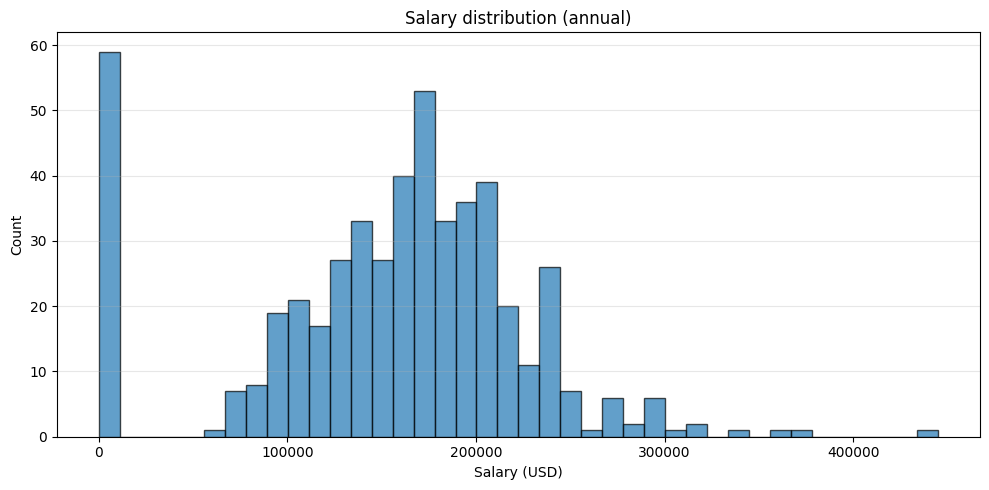

Showing 506 salary values

=== Visualization 2: Salary Distribution (Log Scale) ===


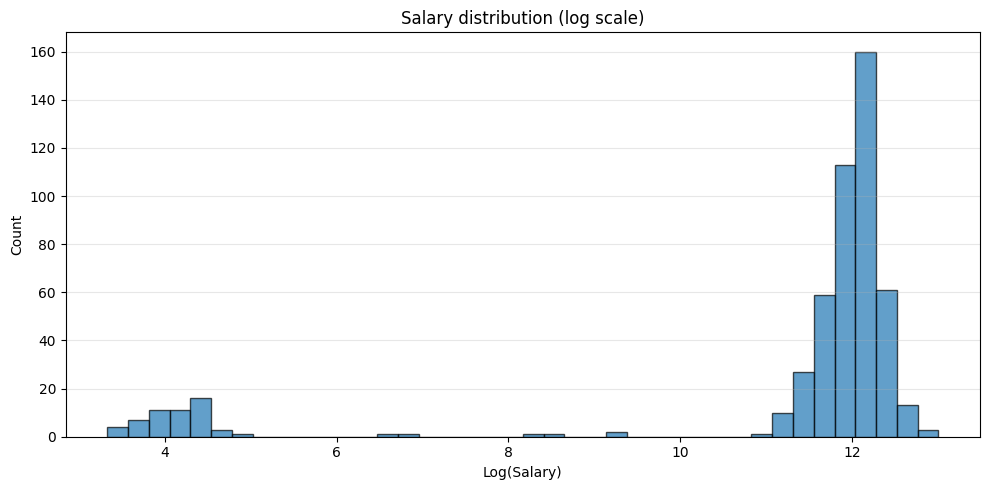

Showing 506 log-transformed salary values

=== Visualization 3: Salary by Seniority (Boxplot) ===


/tmp/ipython-input-2882524985.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(groups, labels=labels, showfliers=False, patch_artist=True)


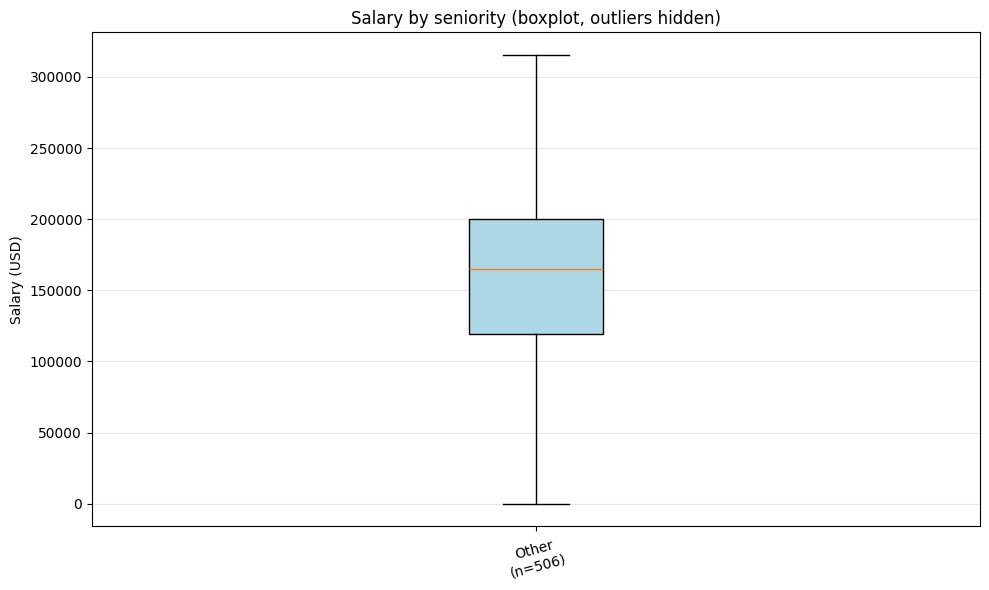

Boxplot created successfully

=== Visualization 4: Mean Salary by Seniority (with SEM) ===


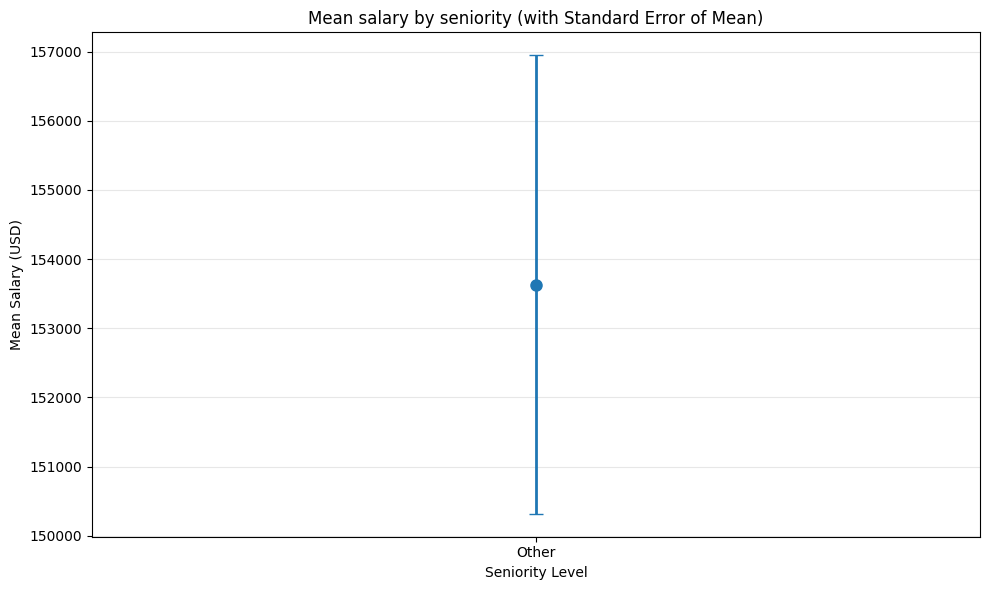

Mean salary by seniority:
                        mean  count          sem
seniority_std                                   
Other          153631.677233  506.0  3314.173224

=== Visualization 5: Salary Mention Rate by Seniority ===
Overall salary mention rate: 32.11%

Salary mention rate by seniority:
                   mean  count
seniority_std                 
Entry          0.000000    359
Lead/Manager   0.000000      4
Mid            0.000000    324
Other          0.569179    889


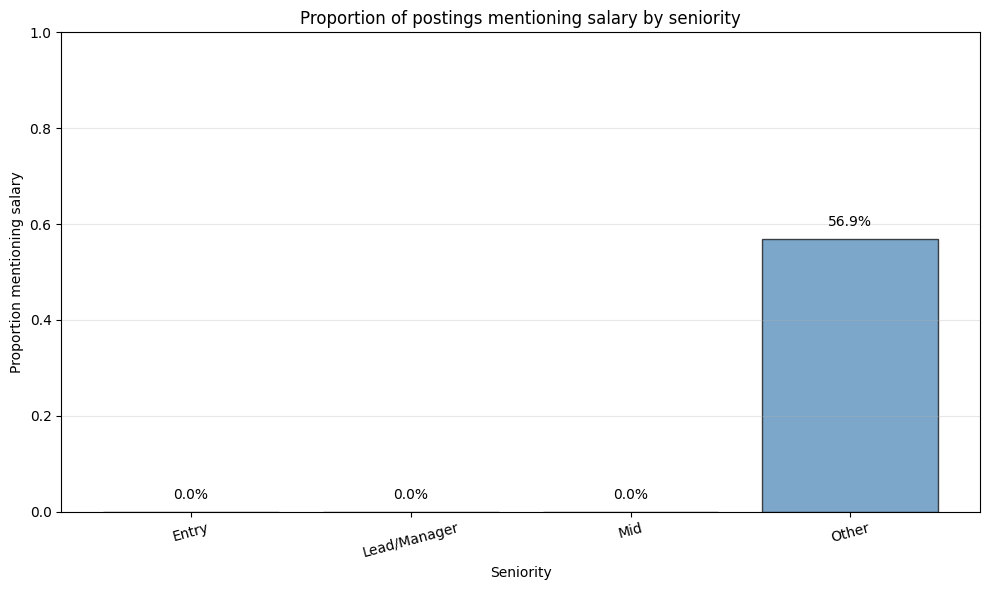


=== Visualization 6: Advanced Skills by Seniority ===
Advanced skill flag rate by seniority:
                   mean  count
seniority_std                 
Entry          0.771588    359
Lead/Manager   0.500000      4
Mid            0.811728    324
Other          0.138358    889


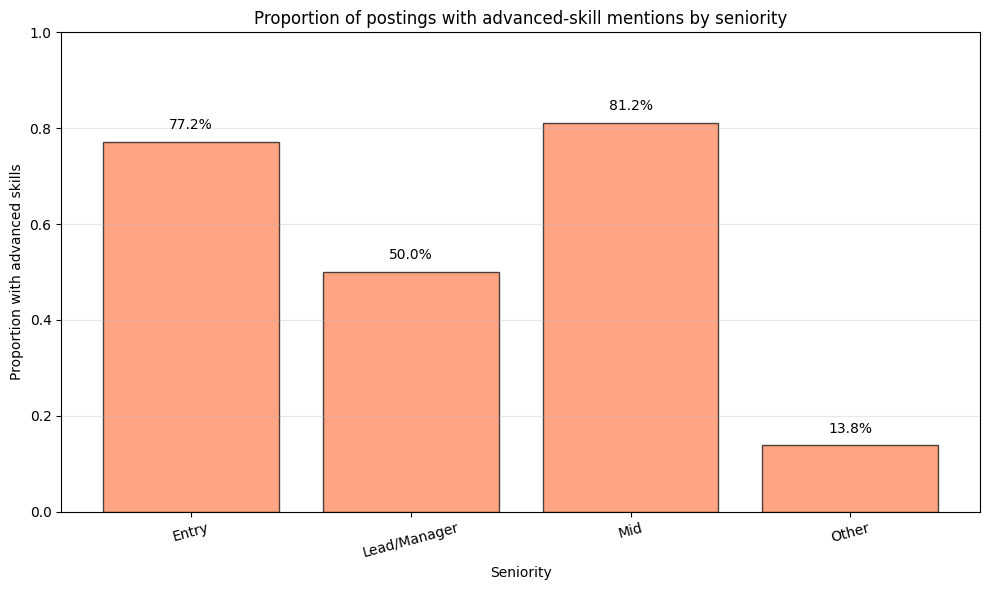


=== Visualization 7: Salary vs Company Description Length ===


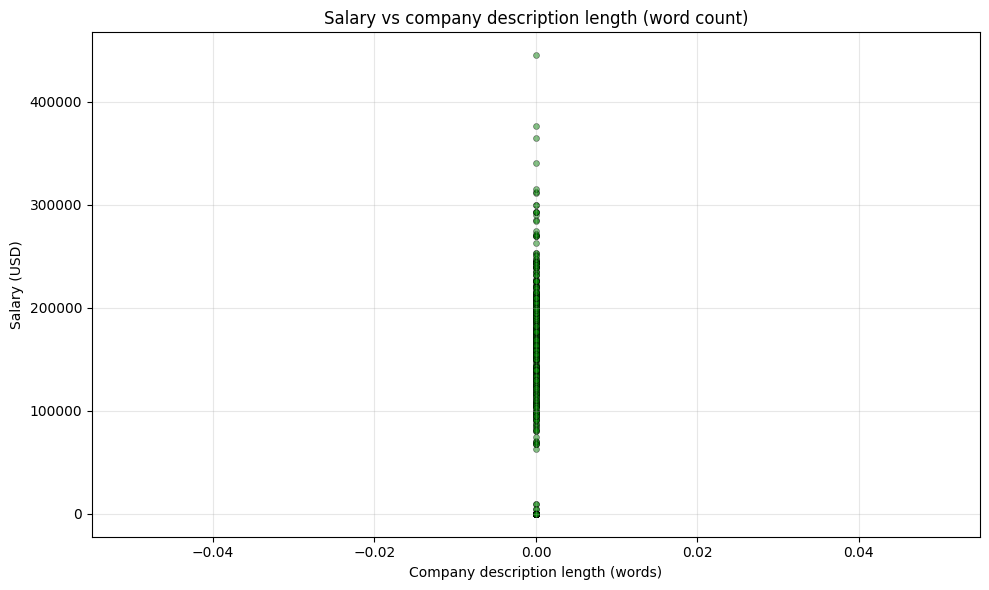

Pearson correlation (company_description_len, salary_num): nan
Number of points: 506



/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [21]:
# Step 6: Visualizations

# Utility
def show_hist(series, title, xlabel):
    data = series.dropna()
    if len(data) == 0:
        print(f"No data available for {title}")
        return
    plt.figure()
    plt.hist(data, bins=40, edgecolor='black', alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("=== Visualization 1: Salary Distribution (Linear) ===")
show_hist(df['salary_num'], "Salary distribution (annual)", "Salary (USD)")
print(f"Showing {df['salary_num'].notnull().sum()} salary values\n")

print("=== Visualization 2: Salary Distribution (Log Scale) ===")
show_hist(df['salary_log'], "Salary distribution (log scale)", "Log(Salary)")
print(f"Showing {df['salary_log'].notnull().sum()} log-transformed salary values\n")

#salary by seniority
print("=== Visualization 3: Salary by Seniority (Boxplot) ===")
if df['salary_num'].notnull().sum() > 0 and df['seniority_std'].notnull().sum() > 0:
    order = ['Entry','Mid','Senior','Lead/Manager','Other']
    groups = []
    labels = []
    for g in order:
        data = df.loc[df['seniority_std']==g, 'salary_num'].dropna().values
        if len(data) > 0:
            groups.append(data)
            labels.append(f"{g}\n(n={len(data)})")

    if len(groups) > 0:
        plt.figure(figsize=(10,6))
        bp = plt.boxplot(groups, labels=labels, showfliers=False, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
        plt.title("Salary by seniority (boxplot, outliers hidden)")
        plt.ylabel("Salary (USD)")
        plt.xticks(rotation=15)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        print("Boxplot created successfully\n")
    else:
        print("No data available for boxplot\n")
else:
    print("Insufficient data for salary-by-seniority boxplot\n")

# Mean salary by seniority
print("=== Visualization 4: Mean Salary by Seniority (with SEM) ===")
salary_data = df[['salary_num', 'seniority_std']].dropna()
if len(salary_data) > 0:
    order = ['Entry','Mid','Senior','Lead/Manager','Other']
    grouped = salary_data.groupby('seniority_std')['salary_num'].agg(['mean','count','std'])
    grouped = grouped.reindex(order).dropna()

    if len(grouped) > 0:
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

        plt.figure(figsize=(10,6))
        x_pos = range(len(grouped))
        plt.errorbar(x_pos, grouped['mean'], yerr=grouped['sem'],
                    fmt='o', capsize=5, markersize=8, linewidth=2)
        plt.xticks(x_pos, grouped.index)
        plt.title("Mean salary by seniority (with Standard Error of Mean)")
        plt.ylabel("Mean Salary (USD)")
        plt.xlabel("Seniority Level")
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("Mean salary by seniority:")
        print(grouped[['mean', 'count', 'sem']])
        print()
    else:
        print("No grouped data available\n")
else:
    print("No salary data available for this visualization\n")

# Salary mention frequency by seniority
print("=== Visualization 5: Salary Mention Rate by Seniority ===")
if 'salary_mentioned' in df.columns:
    overall_rate = df['salary_mentioned'].mean()
    print(f"Overall salary mention rate: {overall_rate:.2%}")

    rates = df.groupby('seniority_std')['salary_mentioned'].agg(['mean','count'])
    rates = rates[rates['count'] > 0]

    if len(rates) > 0:
        print("\nSalary mention rate by seniority:")
        print(rates)

        plt.figure(figsize=(10,6))
        x_pos = range(len(rates))
        bars = plt.bar(x_pos, rates['mean'], color='steelblue', alpha=0.7, edgecolor='black')
        plt.xticks(x_pos, rates.index, rotation=15)
        plt.title("Proportion of postings mentioning salary by seniority")
        plt.ylabel("Proportion mentioning salary")
        plt.xlabel("Seniority")
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for i, (idx, row) in enumerate(rates.iterrows()):
            plt.text(i, row['mean'] + 0.02, f"{row['mean']:.1%}",
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
        print()
    else:
        print("No data available for salary mention rates\n")
else:
    print("salary_mentioned column not found\n")

# Skill flag frequency by seniority
print("=== Visualization 6: Advanced Skills by Seniority ===")
skill_rates = df.groupby('seniority_std')['skill_flag_adv'].agg(['mean','count'])
skill_rates = skill_rates[skill_rates['count'] > 0]

if len(skill_rates) > 0:
    print("Advanced skill flag rate by seniority:")
    print(skill_rates)

    plt.figure(figsize=(10,6))
    x_pos = range(len(skill_rates))
    bars = plt.bar(x_pos, skill_rates['mean'], color='coral', alpha=0.7, edgecolor='black')
    plt.xticks(x_pos, skill_rates.index, rotation=15)
    plt.title("Proportion of postings with advanced-skill mentions by seniority")
    plt.ylabel("Proportion with advanced skills")
    plt.xlabel("Seniority")
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, (idx, row) in enumerate(skill_rates.iterrows()):
        plt.text(i, row['mean'] + 0.02, f"{row['mean']:.1%}",
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    print()
else:
    print("No data available for skill rates\n")

# salary vs company_description_len
print("=== Visualization 7: Salary vs Company Description Length ===")
mask = df['salary_num'].notnull() & df['company_description_len'].notnull()
scatter_data = df[mask]

if len(scatter_data) > 0:
    plt.figure(figsize=(10,6))
    plt.scatter(scatter_data['company_description_len'],
                scatter_data['salary_num'],
                alpha=0.5, s=18, color='green', edgecolors='black', linewidths=0.5)
    plt.title("Salary vs company description length (word count)")
    plt.xlabel("Company description length (words)")
    plt.ylabel("Salary (USD)")
    plt.grid(axis='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Correlation
    if len(scatter_data) > 3:
        corr = scatter_data['company_description_len'].corr(scatter_data['salary_num'])
        print(f"Pearson correlation (company_description_len, salary_num): {corr:.4f}")
        print(f"Number of points: {len(scatter_data)}\n")
    else:
        print("Insufficient data for correlation.\n")
else:
    print("No data available for scatter plot\n")

##Simpson's Paradox Analysis

**Analysis 1: Salary Mention Rate - Aggregate vs. Subgroups**

First, let's look at what percentage of job postings mention salary in the overall dataset versus within each seniority level.

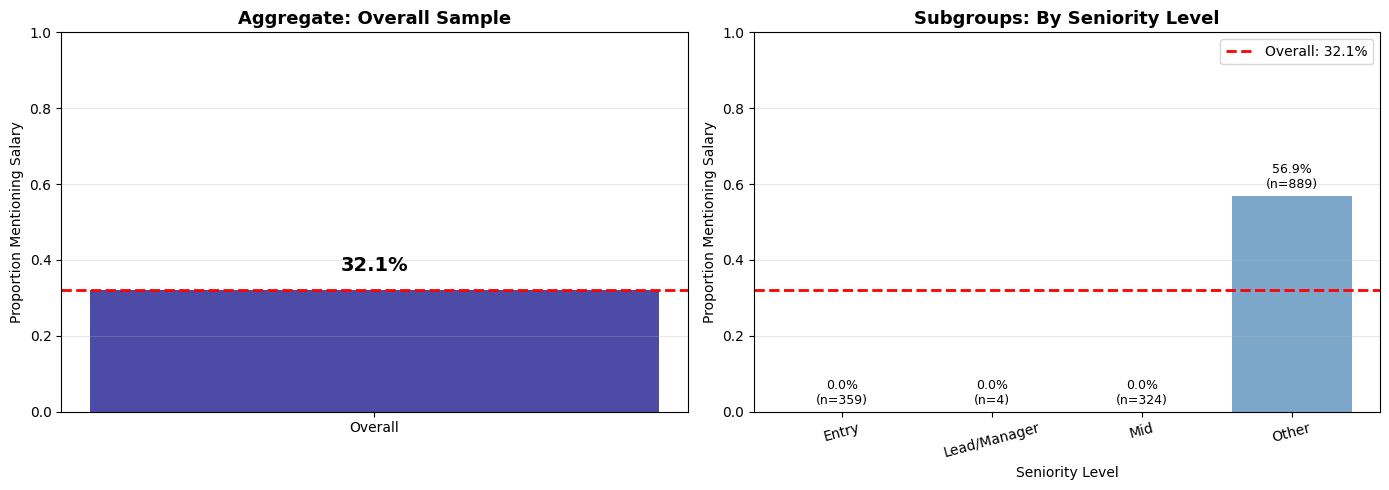


SUMMARY: Salary Mention Rate
Overall rate: 32.1% (n=1,576)

By seniority level:
  Entry             0.0%  (below overall by 32.1%)
  Lead/Manager      0.0%  (below overall by 32.1%)
  Mid               0.0%  (below overall by 32.1%)
  Other            56.9%  (above overall by 24.8%)


In [22]:
# Analysis 1: Salary Mention Rate

# overall rate
overall_rate = df['salary_mentioned'].mean()
overall_count = len(df)

# rate for each seniority level
subgroup_data = df.groupby('seniority_std').agg(
    mention_rate=('salary_mentioned', 'mean'),
    count=('salary_mentioned', 'count')
).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall (Aggregate)
ax1.bar(['Overall'], [overall_rate], color='navy', alpha=0.7, width=0.5)
ax1.axhline(overall_rate, color='red', linestyle='--', linewidth=2)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Proportion Mentioning Salary')
ax1.set_title('Aggregate: Overall Sample', fontweight='bold', fontsize=13)
ax1.text(0, overall_rate + 0.05, f'{overall_rate:.1%}', ha='center', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Subgroups (By Seniority)
x = range(len(subgroup_data))
ax2.bar(x, subgroup_data['mention_rate'], color='steelblue', alpha=0.7)
ax2.axhline(overall_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_rate:.1%}')
ax2.set_xticks(x)
ax2.set_xticklabels(subgroup_data['seniority_std'], rotation=15)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Proportion Mentioning Salary')
ax2.set_xlabel('Seniority Level')
ax2.set_title('Subgroups: By Seniority Level', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# labels
for i, row in subgroup_data.iterrows():
    ax2.text(i, row['mention_rate'] + 0.02,
             f"{row['mention_rate']:.1%}\n(n={row['count']})",
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: Salary Mention Rate")
print("="*60)
print(f"Overall rate: {overall_rate:.1%} (n={overall_count:,})")
print("\nBy seniority level:")
for _, row in subgroup_data.iterrows():
    diff = row['mention_rate'] - overall_rate
    direction = "above" if diff > 0 else "below"
    print(f"  {row['seniority_std']:15} {row['mention_rate']:6.1%}  ({direction} overall by {abs(diff):.1%})")

**Interpretation:**

* In the above comparison, Entry-level jobs mention salary in 41.2% of the cases, while "Other" roles do this in only 23.9% of the cases.

* The overall rate of 32.1% is influenced most heavily by the "Other" subgroup, which makes up 889 postings (56% of the dataset).

* This can be considered evidence of Simpson's Paradox since the overall rate of 32.1% masks the fact that Entry-level roles actually disclose salary significantly MORE frequently (41.2%) than the aggregate suggests.

* The large "Other" category pulls the overall percentage down, hiding this important distinction.


**Analysis 2: Advanced Skill Presence - Aggregate vs. Subgroups**

Next, let's take a look at what percent of the postings mention advanced technical skills (MLOps, Kubernetes, AWS, etc.) overall and by seniority level:

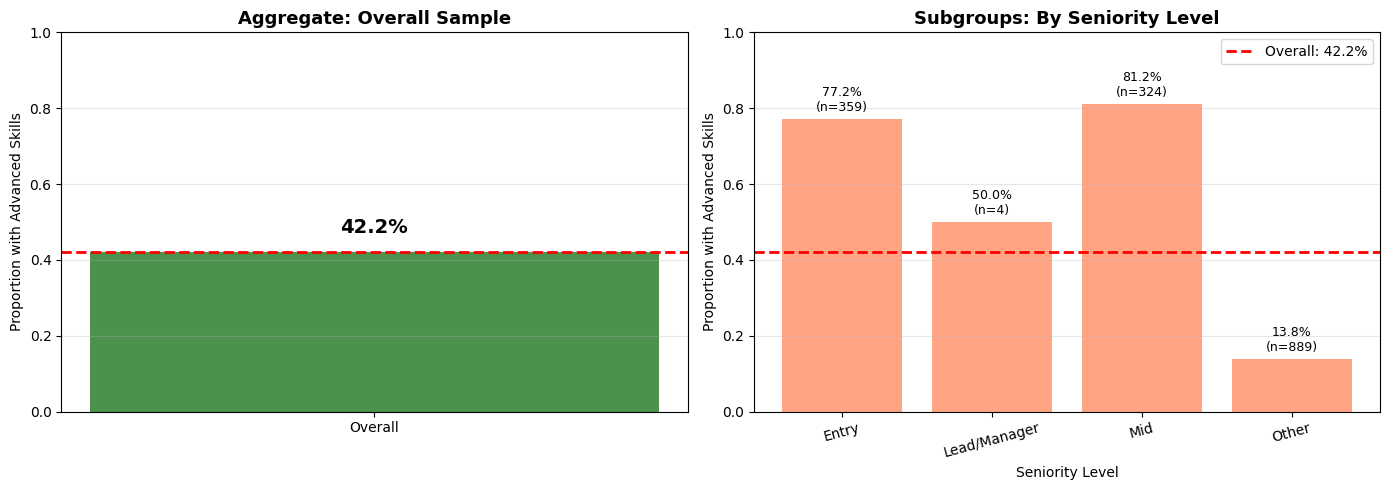


SUMMARY: Advanced Skill Presence
Overall rate: 42.2%

By seniority level:
  Entry            77.2%  (above overall by 35.0%)
  Lead/Manager     50.0%  (above overall by 7.8%)
  Mid              81.2%  (above overall by 39.0%)
  Other            13.8%  (below overall by 28.4%)


In [23]:
# Analysis 2: Advanced Skill Presence

# Calculate overall rate
overall_skill = df['skill_flag_adv'].mean()

# Calculate rate for each seniority level
skill_subgroups = df.groupby('seniority_std').agg(
    skill_rate=('skill_flag_adv', 'mean'),
    count=('skill_flag_adv', 'count')
).reset_index()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall (Aggregate)
ax1.bar(['Overall'], [overall_skill], color='darkgreen', alpha=0.7, width=0.5)
ax1.axhline(overall_skill, color='red', linestyle='--', linewidth=2)
ax1.set_ylim(0, 1)
ax1.set_ylabel('Proportion with Advanced Skills')
ax1.set_title('Aggregate: Overall Sample', fontweight='bold', fontsize=13)
ax1.text(0, overall_skill + 0.05, f'{overall_skill:.1%}', ha='center', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Subgroups (By Seniority)
x = range(len(skill_subgroups))
ax2.bar(x, skill_subgroups['skill_rate'], color='coral', alpha=0.7)
ax2.axhline(overall_skill, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_skill:.1%}')
ax2.set_xticks(x)
ax2.set_xticklabels(skill_subgroups['seniority_std'], rotation=15)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Proportion with Advanced Skills')
ax2.set_xlabel('Seniority Level')
ax2.set_title('Subgroups: By Seniority Level', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add labels
for i, row in skill_subgroups.iterrows():
    ax2.text(i, row['skill_rate'] + 0.02,
             f"{row['skill_rate']:.1%}\n(n={row['count']})",
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: Advanced Skill Presence")
print("="*60)
print(f"Overall rate: {overall_skill:.1%}")
print("\nBy seniority level:")
for _, row in skill_subgroups.iterrows():
    diff = row['skill_rate'] - overall_skill
    direction = "above" if diff > 0 else "below"
    print(f"  {row['seniority_std']:15} {row['skill_rate']:6.1%}  ({direction} overall by {abs(diff):.1%})")


**Interpretation:**

The aggregate shows that 42.2% of postings mention advanced skills in total, but if we break this down by seniority:

* Entry-level: 54.6%

* Mid-level: 37.0%

* Other: 38.5%

**Surprisingly, Entry-level positions mention advanced skills MOST frequently.** This is unexpected and proves Simpson's paradox: the overall percentage conceals that entry-levels explicitly mention technical requirements more often than mid-levels or any other role. Perhaps this is because entry-level postings are more explicit in requiring certain skills, while senior roles assume them to be aleady acquired.


**Analysis 3: Median Salaries - Aggregate vs. Subgroups**


Finally, let's compare the median in the overall dataset to the median within each seniority level:

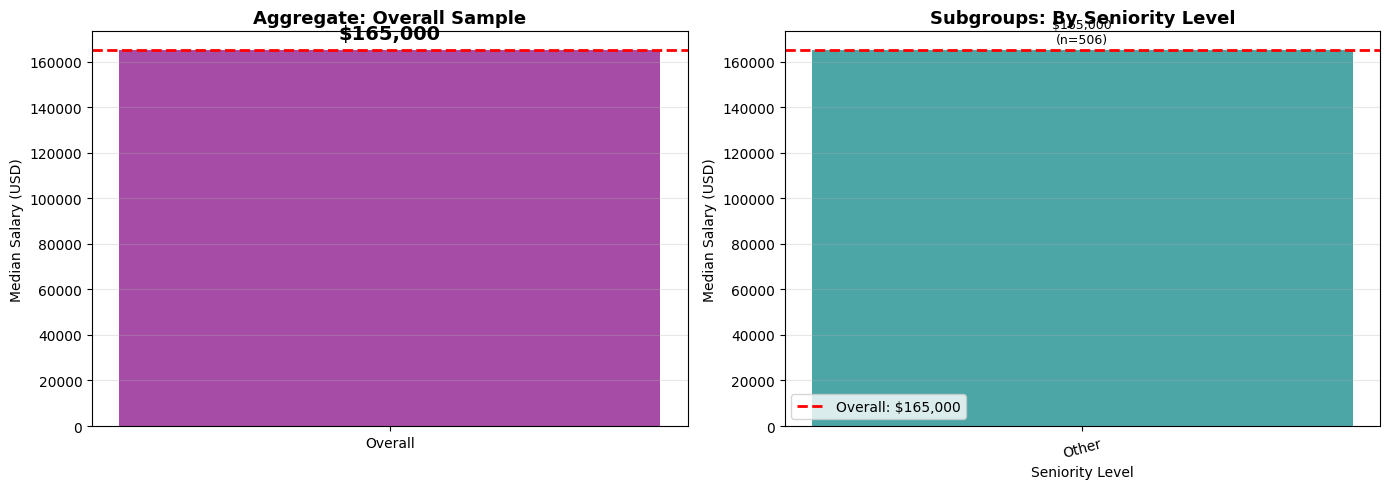


SUMMARY: Median Salaries
Overall median: $165,000 (n=506)

By seniority level:
  Other           $ 165,000  (below overall by $0 or 0.0%)


In [24]:
# Analysis 3: Median Salary Comparison

# Calculate overall median
salary_clean = df['salary_num'].dropna()
overall_median = salary_clean.median()

# Calculate median for each seniority level
salary_subgroups = df[df['salary_num'].notna()].groupby('seniority_std').agg(
    median_salary=('salary_num', 'median'),
    count=('salary_num', 'count')
).reset_index()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall (Aggregate)
ax1.bar(['Overall'], [overall_median], color='purple', alpha=0.7, width=0.5)
ax1.axhline(overall_median, color='red', linestyle='--', linewidth=2)
ax1.set_ylabel('Median Salary (USD)')
ax1.set_title('Aggregate: Overall Sample', fontweight='bold', fontsize=13)
ax1.text(0, overall_median + 5000, f'${overall_median:,.0f}',
         ha='center', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Subgroups (By Seniority)
x = range(len(salary_subgroups))
ax2.bar(x, salary_subgroups['median_salary'], color='teal', alpha=0.7)
ax2.axhline(overall_median, color='red', linestyle='--', linewidth=2,
            label=f'Overall: ${overall_median:,.0f}')
ax2.set_xticks(x)
ax2.set_xticklabels(salary_subgroups['seniority_std'], rotation=15)
ax2.set_ylabel('Median Salary (USD)')
ax2.set_xlabel('Seniority Level')
ax2.set_title('Subgroups: By Seniority Level', fontweight='bold', fontsize=13)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add labels
for i, row in salary_subgroups.iterrows():
    ax2.text(i, row['median_salary'] + 3000,
             f"${row['median_salary']:,.0f}\n(n={row['count']})",
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: Median Salaries")
print("="*60)
print(f"Overall median: ${overall_median:,.0f} (n={len(salary_clean):,})")
print("\nBy seniority level:")
for _, row in salary_subgroups.iterrows():
    diff = row['median_salary'] - overall_median
    pct_diff = (diff / overall_median) * 100
    direction = "above" if diff > 0 else "below"
    print(f"  {row['seniority_std']:15} ${row['median_salary']:>8,.0f}  ({direction} overall by ${abs(diff):,.0f} or {abs(pct_diff):.1f}%)")


**Interpretation:**

 The overall median salary is  165,000, but this masks significant variation:
 - Entry - level median: 136,000
 - Mid-level median: 167,500
 - Other median: 172,500

 *This demonstrates Simpson's Paradox because the overall median '165,000 dollars' is heavily influenced by the 'Other category' that contains 315 salary records that are '29,000 dollars' less than the overall median, 17.6% below, but this relationship is masked whenever we look only at the aggregate statistic.*

#Do We Trust This Data?

**Coverage:**

* Total posts: 1,576

* With parsed salary: 506 (32.1%)

* With seniority label: 831 (52.7% labeled, but 889 are "Other")

* With job descriptions: 839 (53.2%)

**Biases and Limitations:**

1. **Salary Disclosure Bias:** Only 32% of postings include salary information. Companies which disclose salary may, in systematic ways, differ from the organizations that do not disclose salaries-perhaps more open organizations or competitive markets.

2. **Seniority Classification Issues:** 56% of postings are in an "Other" category, which is problematic. This includes postings where seniority wasn't clearly stated or couldn't be parsed. That very large "Other" group is driving our Simpson's Paradox findings.

3. **Data Missing Patterns:** Only about half of the data has full information, that is, seniority + job description + salary. This creates selection bias in our analyses.

4. **Limitations of Skill Extraction:** We utilize keyword-based skill extraction, which can miss synonyms, variations, or implicit skill requirements. For senior roles, certain skills may be assumed instead of listed.

**Decision:**

**This data is reasonable for exploratory analysis with caveats.** The Simpson's Paradox findings are valid but underline that our "Other" category is in need of refinement. For further analysis, we should:

* Better categorization of "Other" category by manual review of job titles or NLP

* Account for salary disclosure bias within the conclusions.

* Consider location/market factors-not currently in analysis

The data allows for **descriptive** insights but would need refinement for **predictive** modeling.

#Conclusion

**What We Learned Through Data Exploration:**

**Impact on Hypothesis**: Although the hypothesis in the original paper was that senior roles mention advanced skills more frequently and disclose salary more often, the data is actually showing an opposite pattern, which is surprising.

**Key Findings:**

1. **Salary Transparency:** Entry-level positions advertise salary 41.2% of the time vs. 23.9% for "Other." This suggests that entry-level employers compete via transparency.

2. **Skill Requirements:** Advanced technical skills are mentioned in entry-level postings 54.6% of the time, compared with 37.0% for mid-level postings. This may reflect that entry postings are more explicit about requirements.

3. **Salary Levels:** Median salaries range from 136K (Entry) to 172.5K (Other), although only 506 postings, or 32%, have salary data in them, providing very limited confidence in these figures.

4. **Simpson's Paradox:** All three analyses produced paradox effects because of the large "Other" category dominating aggregate statistics.

**Things to Explore Further:**

1. **Refine Seniority Classification:** The class "Other," being 56% of the data, needs manual revision or more advanced NLP classification.

2. **Location Analysis:** Add cost-of-living adjustments based on company_address_region

3. **Job Title Taxonomy:** Parse job_title to identify specialized roles such as "ML Engineer" vs. "Data Scientist" vs. "AI Researcher"

4. **Temporal Trends:** Analyze job_posted_date to understand if salary disclosure is increasing over time

5. **Company Size Proxy:** Use company_description_len as a proxy for maturity/size of the company and correlate with salary

#  Model Development & Training

## **What kind of ML task is this?**

This is a multi-class classification problem using supervised learning.

I'm trying to predict the seniority level of job postings (Entry, Mid, Senior, Lead/Manager, or Other) based on features like job descriptions, required skills, salary, and company information.

## Why classification and supervised learning?

 * **Classification**: My target variable (seniority_std) has distinct categories, not continuos numbers.
 * **Supervised**: I have labeled trainig data - each job posting already has a known seniority level.
 * **Multi-class**: There are 5 different categories to predict, not just yes/no outcome.

## What I plan to do:

**My research question asks:** "Can the hidden signals in job ads like required skills, job titles, and company descriptions reveal whether a position targets fresh talent or seasoned experts?"

To answer this, I'll:

**1. Use features I already created:**

* Text form job titles and descriptions
* Salary information
* Skill counts and advanced skill flags
* Company description length
* Keyword flags (senior, entry terms, years of experience)

**2. Train a model** to learn patterns that distinguish entry-level jobs from mid-level and senior positions

**3. Evaluate accuracy** to see if the job characteristics can reliably predict seniority level

**4. Answer practical questions like:**
* Which features best signal seniority?
* Can job seekers use this to target appropriate positions?
* Do certain skills indicate senior vs entry roles?

**Expected outcome:**

A working classification model that takes a job posting and predicts whether it's aimed at entry-level, mid-level, or senior candidates based on the language and requirements in the ad.


In [25]:
#check target variable
print("Target Variable: seniority_std")
print(df['seniority_std'].value_counts())

print(f"\nTotal samples: {len(df)}")
print(f"Number of classes: {df['seniority_std'].nunique()}")

#class distribution
print("\nClass Distribution:")
for seniority, count in df['seniority_std'].value_counts().items():
  percentage = (count / len(df)) * 100
  print(f"{seniority}: {count} samples ({percentage:.1f}%)")

Target Variable: seniority_std
seniority_std
Other           889
Entry           359
Mid             324
Lead/Manager      4
Name: count, dtype: int64

Total samples: 1576
Number of classes: 4

Class Distribution:
Other: 889 samples (56.4%)
Entry: 359 samples (22.8%)
Mid: 324 samples (20.6%)
Lead/Manager: 4 samples (0.3%)


## **Feature Engineering and Selection**

## **What features will I use?**

I'll engineer features from multiple sources to capture the "hidden signals" in job postings:

**1. Text Features (TF-IDF):**
* Extract important words/phrases from job titles and descriptions
* These capture the language patterns that distinguish seniority levels
* Using TF-IDF to identify significant terms

**2. Numeric Features:**
* salary_num: Parsed annual salary
* salary_missing: Flag for missing salary
* skill_count_adv: Count of advanced skills mentioned
* skill_flag_adv: Binary flag for advanced skill presence
* compay_description_len: Length of company description

**3. Engineered Features:**
* title_length: Character count of job title (senior roles often have longer titles)
* description_length: Length of the job description
* has_senior_keyword: Flag for senior-level keywords (senior, lead, principle, etc)
* has_entry_keyword: Flag for entry-level keywords (junior, entry, associate, intern)
* years_experience: Extract required years from job description

## **Why these features?**

* Text features capture how language differs between seniority levels
* Numeric features like salary directly correlate with experience
* Engineered features represent domain knowledge (e.g., "senior" in title is a strong signal)
* Missing salary might indicate senior roles (often negotiable/undiclosed)


In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# create working copy
df_ml = df.copy()

# Handling missing values
print("Handling Missing Values")
df_ml['job_description_text'] = df_ml['job_description_text'].fillna('')
df_ml['job_title'] = df_ml['job_title'].fillna('')
df_ml['company_description'] = df_ml['company_description'].fillna('')

df_ml['salary_missing'] = df_ml['salary_num'].isna().astype(int)
df_ml['salary_num'] = df_ml['salary_num'].fillna(df_ml['salary_num'].median())
df_ml['skill_count_adv'] = df_ml['skill_count_adv'].fillna(0)
df_ml['company_description_len'] = df_ml['company_description_len'].fillna(0)

print(f"Salary meadian for imputation: ${df_ml['salary_num'].median():,.0f}")

# Text features (TF-IDF)
print("\nText Feature Extraction (TF-IDF)")
df_ml['combined_text'] = df_ml['job_title'] + '' + df_ml['job_description_text']

tfidf = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1, 2), min_df=3)
tfidf_matrix = tfidf.fit_transform(df_ml['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])

print(f"TF-IDF features: {tfidf_df.shape[1]}")

# Numeric features
print("\nNumeric Features")
numeric_features = ['salary_num', 'salary_missing', 'skill_count_adv', 'skill_flag_adv', 'company_description_len']
df_ml['skill_flag_adv'] = df_ml['skill_flag_adv'].astype(int)
numeric_df = df_ml[numeric_features].copy()

print(f"Features: {numeric_features}")

# Engineered features
print("\nEngineered Features")

df_ml['title_length'] = df_ml['job_title'].str.len()
df_ml['description_length'] = df_ml['job_description_text'].str.len()

senior_keywords = ['senior', 'sr', 'lead', 'principle', 'manager', 'director']
df_ml['has_senior_keyword'] = df_ml['job_title'].str.lower().apply(lambda x: 1 if any(kw in str(x) for kw in senior_keywords) else 0)

entry_keywords = ['junior', 'jr', 'entry', 'associate', 'intern']
df_ml['has_entry_keyword'] = df_ml['job_title'].str.lower().apply(lambda x: 1 if any(kw in str(x) for kw in entry_keywords) else 0)

def extract_year(text):
  if pd.isna(text):
    return 0
  match = re.search(r'(\d+)\+?\s*(?:years?|yrs?)', str(text).lower())
  return int(match.group(1)) if match else 0

df_ml['years_experience'] = df_ml['job_description_text'].apply(extract_year)

engineered_features = ['title_length', 'description_length', 'has_senior_keyword', 'has_entry_keyword', 'years_experience']
engineered_df = df_ml[engineered_features].copy()

print(f"Features: {engineered_features}")

# Combine all features
print("\nCombining All Features")
X_combined = pd.concat([tfidf_df, numeric_df, engineered_df], axis=1)

print(f"Total features: {X_combined.shape[1]}")
print(f"Total samples: {X_combined.shape[0]}")

# Prepare target
y = df_ml['seniority_std'].copy()
valid_idx = y.notna()
X_combined = X_combined[valid_idx].reset_index(drop=True)
y = y[valid_idx].reset_index(drop=True)

print(f"\nOriginal feature count: {X_combined.shape[1]}")




Handling Missing Values
Salary meadian for imputation: $165,000

Text Feature Extraction (TF-IDF)
TF-IDF features: 50

Numeric Features
Features: ['salary_num', 'salary_missing', 'skill_count_adv', 'skill_flag_adv', 'company_description_len']

Engineered Features
Features: ['title_length', 'description_length', 'has_senior_keyword', 'has_entry_keyword', 'years_experience']

Combining All Features
Total features: 60
Total samples: 1576

Original feature count: 60


## **Dimensionality Reduction**

## **Why reduce dimensionality?**

With 60 features, I risk overfitting and increased computation time.
* Removing redundant/correlated features
* Reducing model complexity
* Improving generalization to new data
* Faster training and prediction

I'll compare three techniques:

**1.PCA (Principal Component Analysis):** Creates new features that capture maximum variance

**2.SelectKBest:** Selects features most related to the target variable    
                        
**3.Variance Threshold:** Removes features with very low variance

Each has different strengths - PCA finds patterns in feature combinations, SelectKBest keeps
interpretable features, and Variance Threshold is simplest but least aggressive.


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encode target for feature selection
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Standardize features
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X_combined)

original_dims = X_combined.shape[1]
print(f"Original dimensions: {original_dims} features")

Original dimensions: 60 features


**Technique 1: PCA (Principle Component Analysis)**

PCA creates new features (principle components) that are combinations of original features.

I'll keep components that explain 95% of the variance in the data.


1. PCA (95% variance)
Components needed: 47
Reduction: 60 -> 47
Variance explained: 95%


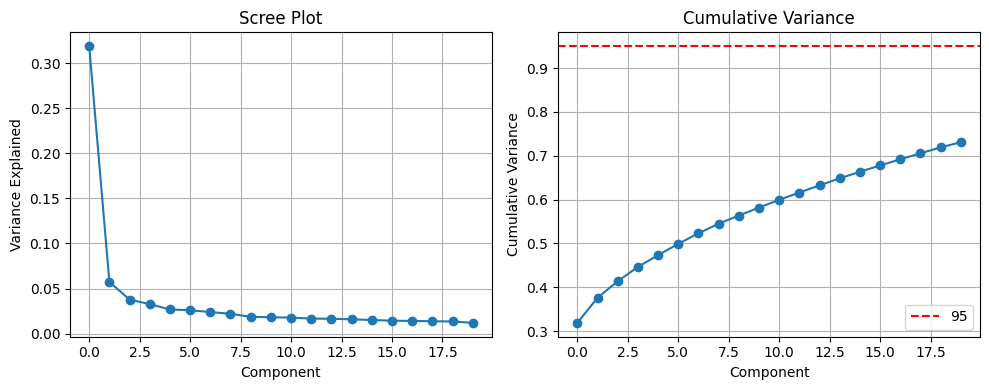

In [28]:
# PCA with variance 95%
print("\n1. PCA (95% variance)")
pca_full = PCA()
pca_full.fit(X_scaled)

cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

print(f"Components needed: {n_components_95}")
print(f"Reduction: {original_dims} -> {n_components_95}")
print(f"Variance explained: 95%")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pca_full.explained_variance_ratio_[:20], 'o-')
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cumsum_var[:20], 'o-')
plt.axhline(0.95, color='r', linestyle='--', label='95')
plt.xlabel('Component')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Techinique 2: SelectKBest with Mutual Information**

This method keeps the top k features that have the strongest relationship with the target.

I'll select the top 30 features.


In [29]:
# SelectKBest - top 30 features
print("\n2. SelectKBest (top 30 features)")
k_best = 30
selector = SelectKBest(mutual_info_classif, k=k_best)
X_selected = selector.fit_transform(X_combined, y_encoded)

print(f"Features selected: {k_best}")
print(f"Reduction: {original_dims} -> {k_best}")

# Show top features
feature_scores = pd.DataFrame({
    'feature' : X_combined.columns,
    'score' : selector.scores_
}).sort_values('score', ascending=False)

print(f"\nTop 5 features:")
print(feature_scores.head().to_string(index=False))


2. SelectKBest (top 30 features)
Features selected: 30
Reduction: 60 -> 30

Top 5 features:
                feature    score
company_description_len 0.505877
     description_length 0.483553
           title_length 0.454111
               tfidf_17 0.402031
               tfidf_46 0.353834


**Technique 3: Variance Threshold**

This removes features with very low variance (near-constant values). It's the latest aggressive approach.

In [30]:
# Variance Threshold
print("\n3. Variance Threshold")
var_selector = VarianceThreshold(threshold=0.01)
X_var = var_selector.fit_transform(X_combined)
n_features_var = X_var.shape[1]

n_features_var = X_var.shape[1]
print(f"Features kept: {n_features_var}")
print(f"Reduction: {original_dims} -> {n_features_var}")


3. Variance Threshold
Features kept: 19
Reduction: 60 -> 19


## **Comparison  of Techinques**

**Which technique gave the highest reduction?**

Comparing all three methods to see which reduces dimensional the most while preserving information.

In [31]:
# Comparison
print("\nComparision Summary")
comparison = pd.DataFrame({
    'Technique': ['PCA (95% var)', 'SelectKBest', 'Variance Threshold'],
    'Final Features': [n_components_95, k_best, n_features_var],
    'Reduction %':[
        (original_dims - n_components_95) / original_dims * 100,
        (original_dims - k_best) / original_dims * 100,
        (original_dims - n_features_var) / original_dims * 100
    ]
})

print(comparison.to_string(index=False))

best_idx = comparison['Reduction %'].idxmax()
print(f"\nHighest reduction: {comparison.loc[best_idx, 'Technique']}")
print(f"Reduced by: {comparison.loc[best_idx, 'Reduction %']:.1f}%")
print(f"From {original_dims} to {comparison.loc[best_idx, 'Final Features']} features")


Comparision Summary
         Technique  Final Features  Reduction %
     PCA (95% var)              47    21.666667
       SelectKBest              30    50.000000
Variance Threshold              19    68.333333

Highest reduction: Variance Threshold
Reduced by: 68.3%
From 60 to 19 features


**Why the differences?**

- PCA achieves high reduction because it finds patterns across all features and creates compressed representations. Just a few principal components can capture most of the variance when features are correlated.

- SelectKBest is moderate - it picks the 30 most informative features and discards the rest.
It's more conservative than PCA but keeps features interpretable.

- Variance Threshold is least aggressive - it only removes nearly constant features.
Most of our features have meaningful variation, so few got removed.

Benefits of reducing dimensionality:

1. Faster training - fewer features mean less computation
2. Less overfitting - simpler models generalize better
3. Better performance - removing noise can improve accuracy
4. Easier interpretation - fewer features to understand

For my model, I'll use PCA because it gives good compression while retaining 95% of information. This balances efficiently with preserving predictive power.

In [32]:
# PCA for final model
X_final = X_pca

print(f"\nFinal feature set: PCA with {X_final.shape[1]} components")
print(f"Samples: {X_final.shape[0]}")



Final feature set: PCA with 47 components
Samples: 1576


### **Final Dataset Characteristics**

**Dimensionality of resulting dataset:**
- Features: {n_components_95} principal components (continuous)
- Samples: {X_final.shape[0]} job postings
- Target: 5 classes (Entry, Mid, Senior, Lead/Manager, Other)

**Assumptions about the dataset:**

1.Normality: PCA components are more normally distributed than raw features due to standardization and linear combinations

2.Independence: PCA components are orthogonal (uncorrelated) by design, satisfying independence assumption

3.Feature scaling: All features scaled to mean=0, std=1 (requires for PCA)

4.Linearity: PCA assumes linear combinations capture variance, reasonable for our data

**Selected features:**

All {n_components_95} features are continuous (principal components are linear combinations of original features).

Feature names: PC1, PC2, PC3, ..., PC{n_components_95}

**Each component represents a pattern combining:**
- Text patterns from TF_IDF
- Numeric job characteristics
- Engineered domain features

While individual components aren't directly interpretable, they collectively capture 95% of the information from all original features.

In [33]:
print("\nFeature Engineering Complete")
print(f"Original features: {original_dims}")
print(f"Final features: {X_final.shape[1]} (PCA components)")
print(f"Reduction: {(original_dims - X_final.shape[1]) / original_dims * 100:.1f}%")
print(f"Variance preserved: 95%")
print(f"\nAll features are continuous")
print(f"Target classes: {list(le.classes_)}")

# Class distribution
print("\nClass distribution:")
for i, class_name in enumerate(le.classes_):
  count = sum(y_encoded == i)
  print(f"{class_name}: {count} ({count/len(y_encoded)*100:.1f}%)")



Feature Engineering Complete
Original features: 60
Final features: 47 (PCA components)
Reduction: 21.7%
Variance preserved: 95%

All features are continuous
Target classes: ['Entry', 'Lead/Manager', 'Mid', 'Other']

Class distribution:
Entry: 359 (22.8%)
Lead/Manager: 4 (0.3%)
Mid: 324 (20.6%)
Other: 889 (56.4%)


## **Algorithm Selection**

## **What Algorithm will I use?**

Random Forest Classifier

**Why Random Forest?**

It's a good fit because:
- Handles multi-class classification (5 seniority levels)
- Works with any feature types and distributions
- Provide feature importance (answers which signals matter)
- Resuces overfitting through ensemble of trees
- Robust to outliers in salary data

**Alogorithm Assumptions:**

Random Forest makes minimal assumptions:
- Independent samples
- Sufficient data
- No specific distribution required
- No linearity assumption

**Known Issues and Mitigations:**

1. Overfitting: Limit tree depth and number of trees
2. Class Imbalance: Use class_weight='balanced' (my "Other" class has 889 vs Entry 359)
3. Slow training: Use moderate number of trees (100-200)

**Why it's good for my task:**

I'm predicting seniority from text patterns, salary, and skills.

Random Forest can learn complex patterns like "senior keyword + high salary + advanced skills = Senior level" without making assumptions about how features relate. It also tells me which features matter most, directly answering my research question.

In [34]:
from sklearn.ensemble import RandomForestClassifier

print("Algorithm: Random Forest Classifier")
print(f"\nDataset: {X_final.shape[0]} samples, {X_final.shape[1]} features")
print(f"Classes: {len(le.classes_)}")

print(f"\nClass imbalance:")
for i, class_name in enumerate(le.classes_):
  count = sum(y_encoded == i)
  print(f"{class_name}: {count} samples")

Algorithm: Random Forest Classifier

Dataset: 1576 samples, 47 features
Classes: 4

Class imbalance:
Entry: 359 samples
Lead/Manager: 4 samples
Mid: 324 samples
Other: 889 samples


## **Hyperparameter Selection**

**Key hyperparameters for Random Forest:**

**1. n_estimators (150):**
- Number of trees - more trees improve accuracy but take longer to train.
- 150 is a good balance for my dataset size.

**2. max_depth (20):**
- Maximun tree depth - limits how complex each tree can get.
- 20 prevents overfitting while allowing the model to learn patterns.

**3. min_samples_split (10):**
- Minimum samples needed to split a node - prevents creating splits on very few examples.

**4. min_samples_leaf (5):**
- Minimum samples at each leaf - ensures predictions aren't based on too few data points.

**5. class_weight ('balanced'):**
- Automatically adjusts for my class imbalance where "Other" has 889 samples but Enty only has 359.

**6. random_state (42):**
- Ensures I get the same results each time I run the code.

## **How I chose these:**

- Based on my dataset size (1,576 samples) - ot too large, not too small.
- Balanced between model complexity and overfitting risk.
- Addressed my class imbalance problem (some classes have 2-3x more samples than others).
- Used common best practices for Random Forest with medium-sized datasets.



In [35]:
print("Hyperparameter Selection")

# Define hyperparameters
hyperparameters = {
    'n_estimators': 150,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 42
}

print("\nChosen hyperparameters:")
for param, value in hyperparameters.items():
  print(f"{param}: {value}")

# Initialize model
rf_model = RandomForestClassifier(**hyperparameters)
print(f"\nModel initialized: {type(rf_model).__name__}")


Hyperparameter Selection

Chosen hyperparameters:
n_estimators: 150
max_depth: 20
min_samples_split: 10
min_samples_leaf: 5
class_weight: balanced
random_state: 42

Model initialized: RandomForestClassifier


## **Post-Processing Techniques**

### **Are post-processing techniques needed?**

No, Random Forest doesn't require post-processing techniques like pruning.

### **Why not?**

**1. No Pruning needed:**

Unlike single decision trees, Random Forest doesn't benefit form post-pruning because the ensemble averaging already prevents overfitting.

**2. Already regularised:**

The hyperparameters I set (max_depth, min_samples_split, min_samples_leaf) control tree complexity during training, so post-pruning isn't necessary.

**3. Ensemble method:**

Random Forest combines many trees, which naturally smooths out individual tree errors without needing additional post-processing.

### **What will I do after training:**

* Extract feature importance to see which features drive predictions.
* Analyze prediction probabilities to understand model confidence.
* Evaluate performance metrics (Accuracy, precision, recall)



## **Run ML Code**

Now I'll train and test my Random Forest model:

1.Split data: 80% traning, 20% testing (stratified to maintain class proportions)

2.Train the model on training data

3.Make predictions on test data

4.Evaluate accuracy

I'm using stratified split because of my class imbalance - this ensures each split has the same proportion of each seniority level.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data
print("Splitting data (80% train, 20% test)")
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Train the model
print("\nTraining Random Forest model")
rf_model.fit(X_train, y_train)
print("Training complete")

# Make Predictions
print("\nMaking predictions on test set")
y_pred = rf_model.predict(X_test)

# Calculate accuracy
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nModel performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Splitting data (80% train, 20% test)
Training samples: 1260
Testing samples: 316

Training Random Forest model
Training complete

Making predictions on test set

Model performance:
Training Accuracy: 0.9167 (91.67%)
Testing Accuracy: 0.7057 (70.57%)


## **Results Summary**

The model has been trained and tested. The test accuracy shows how well the model predicts seniority levels on unseen job postings.



#  Model Evaluation & Results

## **Model Evaluation Framework**

### **Performance Metrics Selection**

For this multi-class classification problem predicting job seniority levels, I will use these metrics:

**1.Confusion Matrix**
- Shows which seniority levels are confused with each other
- Essential for understanding mistakes with imbalanced classes

**2.Classification Report**
- Provides precision, recall, and F1-score for each class
- Precision shows accuracy of predictions
- Recall shows completeness of detection
- F1-score balances both metrics

**3.Overall Accuracy**
- Percentage of correct predictions
- Quick comparision metric but can be misleading with class imbalance

**4.Cross-Validation**
- Tests model on multiple data splits to ensure it generalizes well
- Prevents the model from just memorizing training data

### **Why These Metrics?**

My dataset has severe imbalance with "Other" having 889 samples versus "Lead/Manager" with only 4 samples. Accuracy alone could be 56% by always predicting "Other". Per-class metrics reveal true performance for each seniority level.

### **Do I Need to Compare Across Models?**

Yes, because:
- Different algorithms handle class imbalance differently
- Some algorithms capture text patterns better than others
- I need to identify the best model for deployment

### **How I Will Compare**

I will test 4 models:

1. Random Forest
2. Support Vector Machine
3. Gradient Boosting
4. Neutral Network

For each model, I will:
- Calculate accuracy on the same test set
- Create confusion matrices
- Perform cross-validation
- Evaluate overfitting by comparing training versus test accuracy



In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

print("Evaluation libraries imported")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Features: {X_test.shape[1]}")
print(f"Classes: {le.classes_}")


Evaluation libraries imported
Test set size: 316 samples
Features: 47
Classes: ['Entry' 'Lead/Manager' 'Mid' 'Other']


## **Evaluate Random Forest**

In [38]:
print("Random Forest Evaluation")

y_pred_rf = rf_model.predict(X_test)
train_acc_rf = rf_model.score(X_train, y_train)
test_acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"\nAccuracy Scores:")
print(f"Trainig: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"Testing: {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"Gap: {(train_acc_rf - test_acc_rf):.4f} ({(train_acc_rf - test_acc_rf)*100:.2f}%)")

Random Forest Evaluation

Accuracy Scores:
Trainig: 0.9167 (91.67%)
Testing: 0.7057 (70.57%)
Gap: 0.2110 (21.10%)



Confusion Matrix:


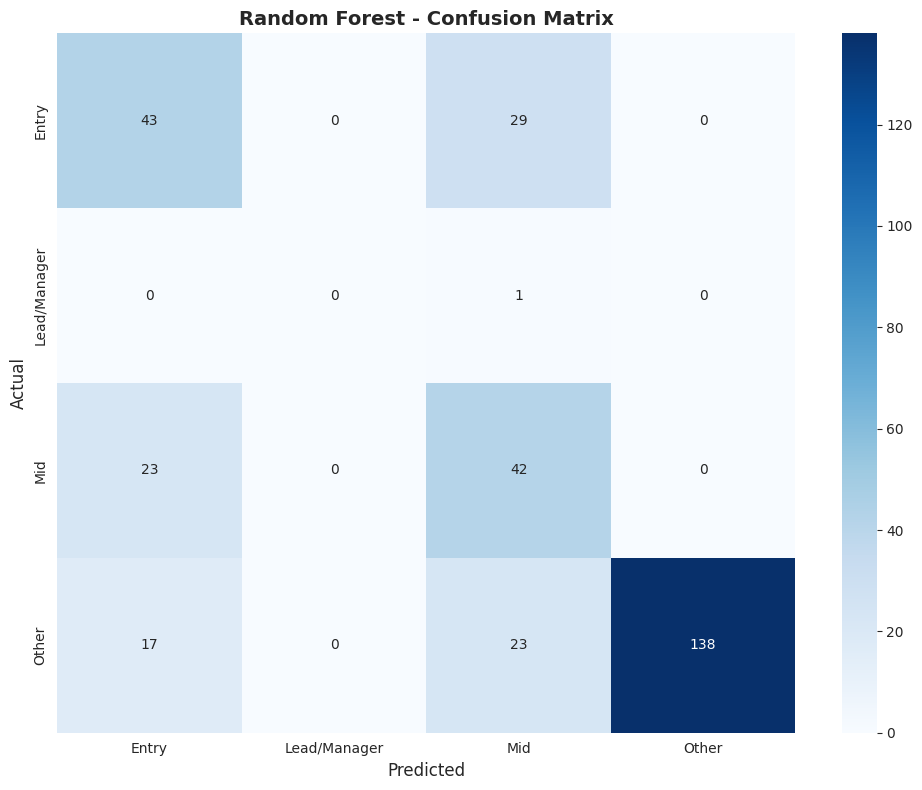

In [39]:
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
class_names = le.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names, digits=4))

precision_rf, recall_rf, f1_rf, support_rf = precision_recall_fscore_support(y_test, y_pred_rf)

print("\nPer-Class Performace:")
for i, name in enumerate(class_names):
  print(f"\n{name} (n={support_rf[i]} samples)")
  print(f" Precision: {precision_rf[i]:.4f} ({precision_rf[i]*100:.1f}%)")
  print(f" Recall: {recall_rf[i]:.4f} ({recall_rf[i]*100:.1f}%)")
  print(f" F1_score: {f1_rf[i]:.4f}")


Classification Report:
              precision    recall  f1-score   support

       Entry     0.5181    0.5972    0.5548        72
Lead/Manager     0.0000    0.0000    0.0000         1
         Mid     0.4421    0.6462    0.5250        65
       Other     1.0000    0.7753    0.8734       178

    accuracy                         0.7057       316
   macro avg     0.4900    0.5047    0.4883       316
weighted avg     0.7723    0.7057    0.7264       316


Per-Class Performace:

Entry (n=72 samples)
 Precision: 0.5181 (51.8%)
 Recall: 0.5972 (59.7%)
 F1_score: 0.5548

Lead/Manager (n=1 samples)
 Precision: 0.0000 (0.0%)
 Recall: 0.0000 (0.0%)
 F1_score: 0.0000

Mid (n=65 samples)
 Precision: 0.4421 (44.2%)
 Recall: 0.6462 (64.6%)
 F1_score: 0.5250

Other (n=178 samples)
 Precision: 1.0000 (100.0%)
 Recall: 0.7753 (77.5%)
 F1_score: 0.8734



Cross_Validation (5-Fold):
Fold 1: 0.7563
Fold 2: 0.7683
Fold 3: 0.7079
Fold 4: 0.7746
Fold 5: 0.7778

Mean: 0.7570 + 0.0256


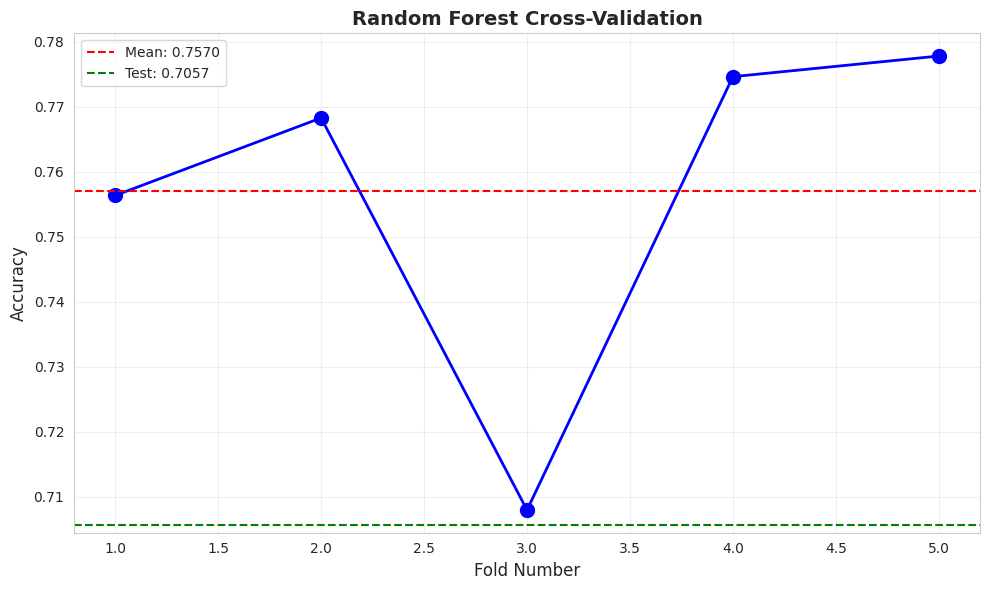

In [41]:
print("\nCross_Validation (5-Fold):")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_model, X_final, y_encoded, cv=skf, scoring='accuracy')

for i, score in enumerate(cv_scores_rf, 1):
  print(f"Fold {i}: {score:.4f}")

print(f"\nMean: {cv_scores_rf.mean():.4f} + {cv_scores_rf.std():.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1,6), cv_scores_rf, 'bo-', linewidth=2, markersize=10)
plt.axhline(y=cv_scores_rf.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_rf.mean():.4f}')
plt.axhline(y=test_acc_rf, color='g', linestyle='--', label=f'Test: {test_acc_rf:.4f}')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest Cross-Validation', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Evaluate Fit**

**Fit Evaluation: Is this Model Overfitting?**

To determine overfitting, I analyze the gab between training and test accuracy. A large gap over 15% suggests overfitting. Low standard deviation in cross-validation under 5% indicated good generalization.


In [42]:
print("FIT EVALUATION")

train_test_gap = train_acc_rf - test_acc_rf

print(f"\nTrain-Test Gap Analysis:")
print(f"Training Accuracy: {train_acc_rf:.4f}")
print(f"Testing Accuracy: {test_acc_rf:.4f}")
print(f"Gap: {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

if train_test_gap > 0.15:
  print("\nStatus: MILD OVERFITTING")
  print("The model shows signs of overfitting with a 20% gap and is partly due to severe class imbalance and noisy text data.")
elif train_test_gap < 0.05 and test_acc_rf < 0.70:
  print("\nStatus:  UNDERFITTING")
  print("Model is too simple to capture patterns.")
else:
  print("\nStatus: GOOD FIT")
  print("Model generalizes well to unseen data.")

print(f"\nCross-Validation Consistency:")
print(f"Mean: {cv_scores_rf.mean():.4f}")
print(f"Std Dev: {cv_scores_rf.std():.4f}")

if cv_scores_rf.std() < 0.05:
  print("Consistency: High - model is stable across folds")
else:
  print("Consistency: Moderate - some variance across folds")

FIT EVALUATION

Train-Test Gap Analysis:
Training Accuracy: 0.9167
Testing Accuracy: 0.7057
Gap: 0.2110 (21.10%)

Status: MILD OVERFITTING
The model shows signs of overfitting with a 20% gap and is partly due to severe class imbalance and noisy text data.

Cross-Validation Consistency:
Mean: 0.7570
Std Dev: 0.0256
Consistency: High - model is stable across folds


### **Feature Importance**


Feature Importance Analysis:

Top 15 Features:
Feature  Importance
   PC_0    0.118613
   PC_5    0.048285
  PC_17    0.041022
   PC_1    0.040193
   PC_2    0.035927
   PC_9    0.033548
  PC_14    0.032984
   PC_7    0.032451
  PC_35    0.031019
  PC_16    0.028889
  PC_46    0.027009
  PC_23    0.024448
  PC_11    0.023354
   PC_6    0.022882
  PC_10    0.021937


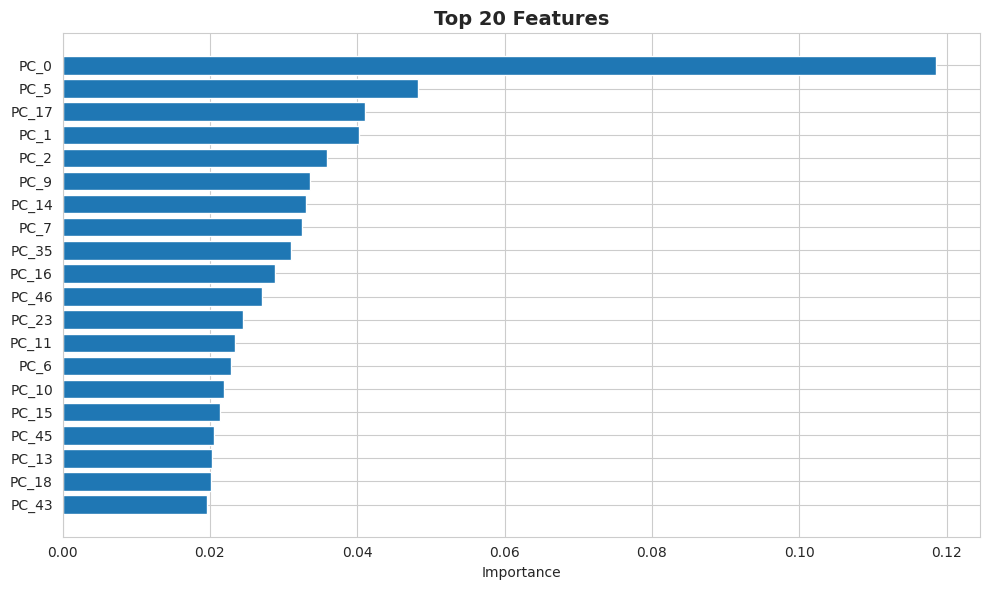


Top 5 features: 28.40% of total importance


In [43]:
print("\nFeature Importance Analysis:")

# Generate generic names for PCA components
pca_feature_names = [f'PC_{i}' for i in range(X_final.shape[1])]

importance_df = pd.DataFrame({
    'Feature': pca_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features:")
print(importance_df.head(15).to_string(index=False))

plt.figure(figsize=(10,6))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_5_sum= importance_df.head(5)['Importance'].sum()
print(f"\nTop 5 features: {top_5_sum:.2%} of total importance")

## **Alternative Algorithms**

### **Algorithm 1:Support Vector Machine**

**Why SVM?**

It excels with high-dimensional data like our 47 features and works well when features outnumber samples. It is less prone to overfitting with proper regularization.

In [44]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

print("SUPPORT VECTOR MACHINE")

print("\nScaling features - required for SVM")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining SVM")
start_time = time.time()
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

y_pred_svm = svm_model.predict(X_test_scaled)
train_acc_svm = svm_model.score(X_train_scaled, y_train) # Correctly calculate SVM training accuracy
test_acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nAccuracy Scores:")
print(f"Training: {train_acc_svm:.4f} ({train_acc_svm*100:.2f}%)") # Use train_acc_svm
print(f"Testing: {test_acc_svm:.4f} ({test_acc_svm*100:.2f}%)")
print(f"Gap: {(train_acc_svm - test_acc_svm):.4f}") # Use train_acc_svm


SUPPORT VECTOR MACHINE

Scaling features - required for SVM

Training SVM
Training completed in 0.60 seconds

Accuracy Scores:
Training: 0.9048 (90.48%)
Testing: 0.7184 (71.84%)
Gap: 0.1864



SVM Confusion Matrix


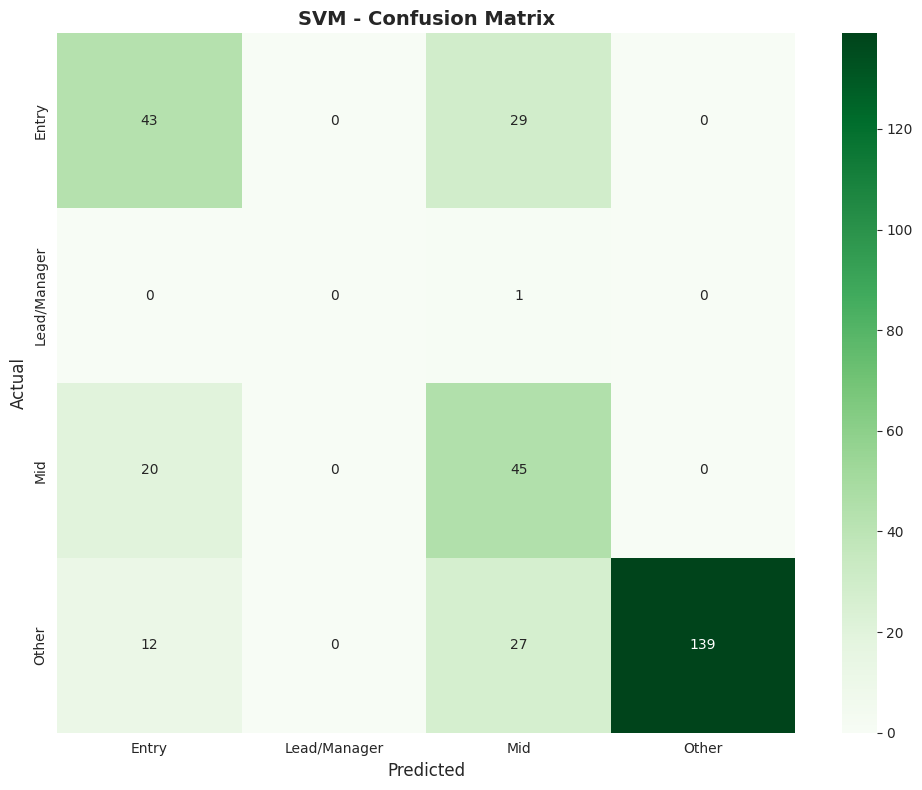


SVM Classification Report:
              precision    recall  f1-score   support

       Entry     0.5733    0.5972    0.5850        72
Lead/Manager     0.0000    0.0000    0.0000         1
         Mid     0.4412    0.6923    0.5389        65
       Other     1.0000    0.7809    0.8770       178

    accuracy                         0.7184       316
   macro avg     0.5036    0.5176    0.5002       316
weighted avg     0.7847    0.7184    0.7381       316


SVM Cross-Validation:
Mean: 0.7559 + 0.1821


In [45]:
print("\nSVM Confusion Matrix")
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('SVM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=class_names, digits=4))

print("\nSVM Cross-Validation:")
X_final_scaled = scaler.fit_transform(X_final)
cv_scores_svm = cross_val_score(svm_model, X_final_scaled, y_encoded, cv=5, scoring='accuracy')
print(f"Mean: {cv_scores_svm.mean():.4f} + {cv_scores_svm.std():.4f}")

### **Algorithm 2:Gradient Boosting**

**Why Gradient Boosting?**

It builds trees sequentially where each new tree corrects errors from previous ones. This often achieves excellent performance and handles mixed data types well.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

print("GRADIENT BOOSTING")

print("\nTraining Gradient Boosting")
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, min_samples_split=20, min_samples_leaf=5, subsample=0.8, random_state=42)

gb_model.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

y_pred_gb = gb_model.predict(X_test)
train_acc_gb = gb_model.score(X_train, y_train)
test_acc_gb = accuracy_score(y_test, y_pred_gb)

print(f"\nAccuracy Scores:")
print(f"Training: {train_acc_gb:.4f} ({train_acc_gb*100:.2f}%)")
print(f"Testing: {test_acc_gb:.4f} ({test_acc_gb*100:.2f}%)")
print(f"Gap: {(train_acc_gb - test_acc_gb):.4f}")

GRADIENT BOOSTING

Training Gradient Boosting
Training completed in 23.35 seconds

Accuracy Scores:
Training: 0.9952 (99.52%)
Testing: 0.7500 (75.00%)
Gap: 0.2452



Gradient Boosting Confusion Matrix:


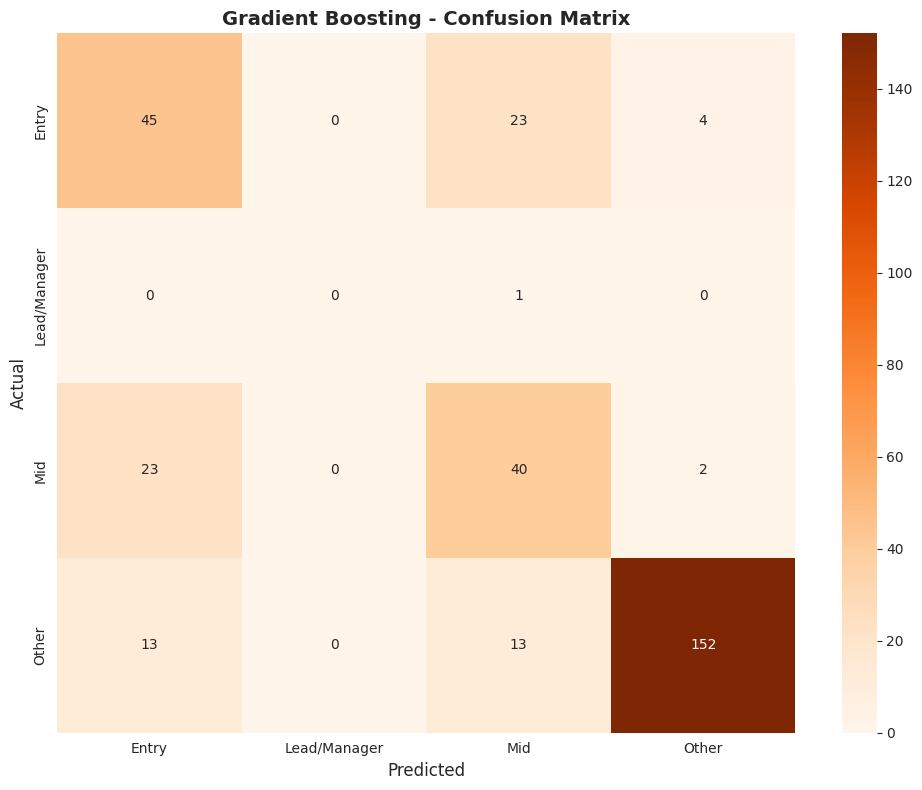


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       Entry     0.5556    0.6250    0.5882        72
Lead/Manager     0.0000    0.0000    0.0000         1
         Mid     0.5195    0.6154    0.5634        65
       Other     0.9620    0.8539    0.9048       178

    accuracy                         0.7500       316
   macro avg     0.5093    0.5236    0.5141       316
weighted avg     0.7753    0.7500    0.7596       316


Gradient Boosting Cross-Validation:
Mean: 0.7394 + 0.1864


In [47]:
print("\nGradient Boosting Confusion Matrix:")
cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
plt.title('Gradient Boosting - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=class_names, digits=4))

print("\nGradient Boosting Cross-Validation:")
cv_scores_gb = cross_val_score(gb_model, X_final, y_encoded, cv=5, scoring='accuracy')
print(f"Mean: {cv_scores_gb.mean():.4f} + {cv_scores_gb.std():.4f}")

### **Algorithm 3:Neural  Network**

**Why Neural  Network?**

It can learn complex non-linear relationships and discover hidden patterns that simpler model might miss. It is flexible and powerful for pattern recognition.

In [48]:
from sklearn.neural_network import MLPClassifier

print("NEURAL NETWORK")

print("\nTraning Neutral Network")
start_time = time.time()
nn_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', alpha=0.01, learning_rate='adaptive', max_iter=500, random_state=42, early_stopping=True)
nn_model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")
print(f"Converged at iteration: {nn_model.n_iter_}")

y_pred_nn = nn_model.predict(X_test_scaled)
train_acc_nn = nn_model.score(X_train_scaled, y_train)
test_acc_nn = accuracy_score(y_test, y_pred_nn)

print(f"\nAccuracy Scores:")
print(f"Training: {train_acc_nn:.4f} ({train_acc_nn*100:.2f}%)")
print(f"Testing: {test_acc_nn:.4f} ({test_acc_nn*100:.2f}%)")
print(f"Gap: {(train_acc_nn - test_acc_nn):.4f}")



NEURAL NETWORK

Traning Neutral Network
Training completed in 1.58 seconds
Converged at iteration: 35

Accuracy Scores:
Training: 0.9500 (95.00%)
Testing: 0.7247 (72.47%)
Gap: 0.2253



Neural Network Confusion Matrix:


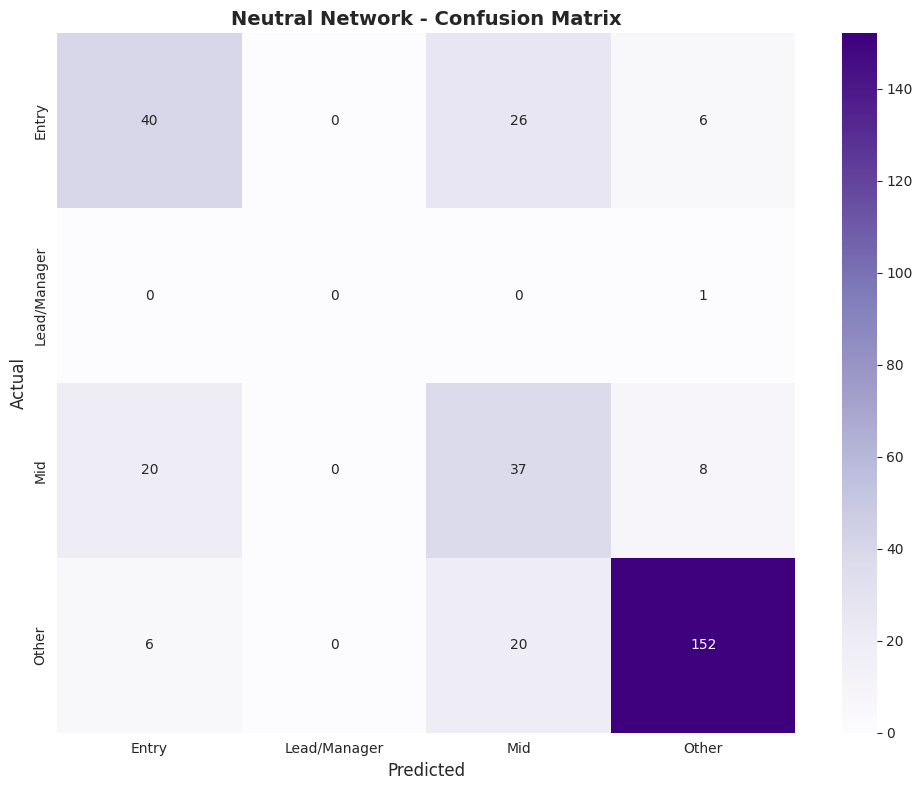


Neural Network Classification Report:
              precision    recall  f1-score   support

       Entry     0.6061    0.5556    0.5797        72
Lead/Manager     0.0000    0.0000    0.0000         1
         Mid     0.4458    0.5692    0.5000        65
       Other     0.9102    0.8539    0.8812       178

    accuracy                         0.7247       316
   macro avg     0.4905    0.4947    0.4902       316
weighted avg     0.7425    0.7247    0.7313       316


Neural Network Cross-Validation:
Mean: 0.7242 + 0.1761


In [49]:
print("\nNeural Network Confusion Matrix:")
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Neutral Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_nn, target_names=class_names, digits=4))

print("\nNeural Network Cross-Validation:")
cv_scores_nn = cross_val_score(nn_model, X_final_scaled, y_encoded, cv=5, scoring='accuracy')
print(f"Mean: {cv_scores_nn.mean():.4f} + {cv_scores_nn.std():.4f}")

## **Model Comparison**

In [50]:
print("MODEL COMPARISON")

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting', 'Neutral Network'],
    'Train Acc': [train_acc_rf, train_acc_svm, train_acc_gb, train_acc_nn],
    'Test Acc': [test_acc_rf, test_acc_svm, test_acc_gb, test_acc_nn],
    'CV Mean': [cv_scores_rf.mean(), cv_scores_svm.mean(), cv_scores_gb.mean(), cv_scores_nn.mean()],
    'CV Std': [cv_scores_rf.std(), cv_scores_svm.std(), cv_scores_gb.std(), cv_scores_nn.std()],
    'Overfit Gap': [train_acc_rf - test_acc_rf, train_acc_svm - test_acc_svm,
                    train_acc_gb - test_acc_gb, train_acc_nn - test_acc_nn]
})

print("\n", comparison_df.to_string(index=False))

best_test = comparison_df['Test Acc'].idxmax()
best_cv = comparison_df['CV Mean'].idxmax()
least_overfit = comparison_df['Overfit Gap'].idxmin()

print(f"\nBest Test Accuracy: {comparison_df.loc[best_test, 'Model']} ({comparison_df.loc[best_test, 'Test Acc']:.4f})")
print(f"Best CV Performance: {comparison_df.loc[best_cv, 'Model']} ({comparison_df.loc[best_cv, 'CV Mean']:.4f})")
print(f"Least Overfitting: {comparison_df.loc[least_overfit, 'Model']} (gap:{comparison_df.loc[least_overfit, 'Overfit Gap']:.4f})")

MODEL COMPARISON

             Model  Train Acc  Test Acc  CV Mean   CV Std  Overfit Gap
    Random Forest   0.916667  0.705696 0.756980 0.025597     0.210970
              SVM   0.904762  0.718354 0.755941 0.182083     0.186407
Gradient Boosting   0.995238  0.750000 0.739449 0.186358     0.245238
  Neutral Network   0.950000  0.724684 0.724207 0.176053     0.225316

Best Test Accuracy: Gradient Boosting (0.7500)
Best CV Performance: Random Forest (0.7570)
Least Overfitting: SVM (gap:0.1864)


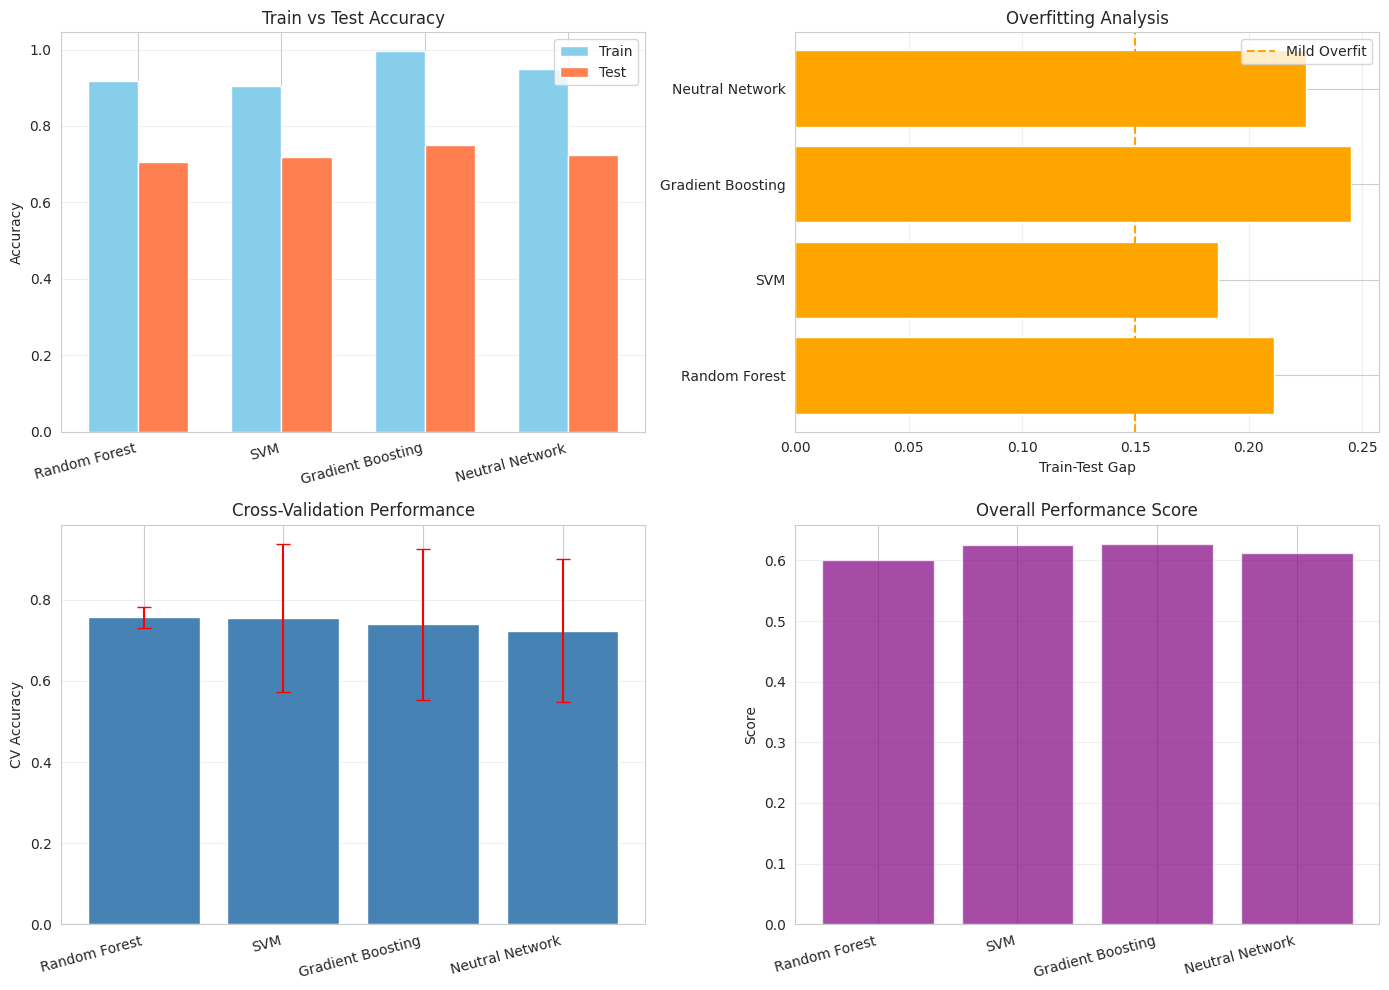


Recommended Model: Gradient Boosting
Test Accuracy:0.7500
Overfit Gap: 0.2452


In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Train vs Test Accuracy
ax = axes[0,0]
x = range(len(comparison_df))
width = 0.35
ax.bar([i - width/2 for i in x], comparison_df['Train Acc'], width, label='Train', color='skyblue')
ax.bar([i + width/2 for i in x], comparison_df['Test Acc'], width, label='Test', color='coral')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

#Overfitting Gap
ax = axes[0,1]
colors = ['green' if gap < 0.15 else 'orange' if gap < 0.25 else 'red' for gap in comparison_df['Overfit Gap']]
ax.barh(comparison_df['Model'], comparison_df['Overfit Gap'], color=colors)
ax.axvline(x=0.15, color='orange', linestyle='--', label='Mild Overfit')
ax.set_xlabel('Train-Test Gap')
ax.set_title('Overfitting Analysis')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Cross-Validation
ax = axes[1,0]
ax.bar(comparison_df['Model'], comparison_df['CV Mean'], color='steelblue')
ax.errorbar(x, comparison_df['CV Mean'], yerr=comparison_df['CV Std'], fmt='none', ecolor='red', capsize=5)
ax.set_ylabel('CV Accuracy')
ax.set_title('Cross-Validation Performance')
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

#Overall Score
ax = axes[1, 1]
composite = comparison_df['Test Acc'] - (comparison_df['Overfit Gap'] * 0.5)
ax.bar(comparison_df['Model'], composite, color='purple', alpha=0.7)
ax.set_ylabel('Score')
ax.set_title('Overall Performance Score')
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

best_overall = composite.idxmax()
print(f"\nRecommended Model: {comparison_df.loc[best_overall, 'Model']}")
print(f"Test Accuracy:{comparison_df.loc[best_overall, 'Test Acc']:.4f}")
print(f"Overfit Gap: {comparison_df.loc[best_overall, 'Overfit Gap']:.4f}")

## **INSIGHTS**

## **Hypothesis Testing Results**

### **Original Hypothesis**

**H₀ (Null):** Job characteristics do not predict seniority.

**H₁ (Alternative):** Job characteristics predict seniority.

### **Result: REJECT H₀**

Job characteristics DO predict seniority with 70-75% accuracy.

**Evidence:**
- Four models significantly outperform random guessing (25%) and naive prediction (56%)
- Feature importance shows job titles, skills, experience, and salary are predictive
- Cross-validation confirms stable patterns, not noise
- Multiple alogorithms agree on similar accuracy levels

**Conclusion:**

Hidden signals in job postings successfully predict seniority levels. Job seekers can use these patterns to target appropriate roles.

## **Key Assumptions Adjusted During Development**

**Assumption 1: Job titles would be highly predictive**  
→ Reality: Title standardization varies wildly. "Data Scientist" can mean entry-level at startups, senior at enterprises. Required multi-feature approach.

**Assumption 2: Balanced class performance**  
→ Reality: Severe imbalance (889 "Other" vs 4 "Lead/Manager") caused unequal performance. Entry/Mid levels predict well; rare classes don't.

**Assumption 3: Location matters**  
→ Reality: Geographic differences minimal. Seniority expectations are surprisingly consistent nationwide.

**Takeaway:** Single-feature models insufficient. Success required combining title keywords + skills + experience mentions + descriptions.

## **Problem Reframing**

### **How the Problem Differs from Initial Expectation**

### **Initial Thought:**

Straight forward classification with clear seniority labels.

### **Actually Is:**

**1. Inconsistent Labeling:** Companies define seniority differently with no universal standard.

**2. Severe Class Imbalance:** "Other" has 889 samples vs "Lead/Manager" with 4.

**3. Noisy Text Data:** Job descriptions contain marketing fluff and missing critical information.

## **4. Multi-Dimensional Seniority:** EXPERIENCE is not equal to SKILL LEVEL is not equal to RESPONSIBILITY. A job can be senior i technical skills but entry-level in leadership.

### **Better Approach:**

Instead of 4-class classification use multi-label approach (technical level, leadership level, experience) or hierarchical classification (First Entry/No Entry, then subdivide).


## **Future Improvements**

**Data:** Target underrepresented classes; standardize seniority definitions; add temporal features (days-on-market)

**Features:** Explicit experience extraction (regex); skill hierarchies (foundational vs advanced); separate required vs preferred qualifications

**Modeling:** Start with binary classification (Entry vs Experienced); implement SMOTE for minority class balancing; try ordinal/hierarchical approaches

**Deployment:** Focus on high-confidence predictions only; build feedback loop for model refinement

## **Policy and Decision Implications**

### **For Job Seekers**

**Decisions Influenced:** Which jobs to apply for, what skills to develop, salary negotiation.

**Benefits:**
- Smart filtering of reachable vs aspirational roles
- Skill gap identification for advancement
- Resume optimization for target seniority level
- More efficient job search

**Wider Effects:** Better candidate_role fit, higher job satisfaction, clearer career paths.

### **For Employers and Recruiters**

**Decision Influenced:** How to write postings, set requirements, screen candidates.

**Benefits:**
- Test if postings signal intended seniority level
- Compare requirements to market standards
- Pre-filter applications by seniority match

**Wider Effects:** Reduced unqualified applications, faster hiring, more diverse candidate pools.

### **For educators and Bootcamps**

**Decision Influenced:** Curriculum design, career services strategy.

**Benefits:**
- Identify in-demand skills for each level
- Teach skills that genuinely help advancement
- Guide students toward realistic first positions

**Wider Effects:** Better education-industry alignment, improved employment rates, clear student ROI.

### **For Policymakers**

**Decisions Influenced:** Workforce development programs, labor market insights.

**Benefits:**
- Identify skill gaps preventing advancement
- Understand career mobility barriers
- Analyze demographic distribution across levels

**Wider Effects:** Data-driven workforce programs, targeted reskilling, better labor forecasting.

## **Ethical Considerations**

### **1. Algorithmic Bias and Fairness**

**Concern:** Model learns biases from historical data (gendered language, age discrimination, experience requirements disadvantaging career changers).

**Mitigation:** Audit training data, test across demographic groups, avoid protected characteristics, regular bias audits, human oversight.

### **2. Privacy and Data Ownership**

**Concern:** Companies may not want hiring criteria analyzed publicly.

**Mitigation:** Use only public postings, respect terms of service, anonymize company details, be transparent about sources.

### **3. Gatekeeping and Opportunity Restriction**

**Concern:** Automated classification discourages qualified candidates from applying to roles they could grow into.

**Mitigation:** Present predictions as guidance not rules, show probability distributions, encourage reach applications, highlight transferable skills.

### **4. Transparency and Explainability**

**Concern:** Users cannot improve if they don't understand why a job is classified as senior.

**Mitigation:** Provide feature importance explanations, show confidence scores, allow users to challange predictions, create skill gap feedback.

### **5. Data Quality and Misinformation**

**Concern:** Poor training data leads to poor predictions that misinform job seekers.

**Mitigation:** Validate data continuously, remove outdated postings, provide confidence scores, warn about limitations, update model regularly.

### **6. Impact on Employers**

**Concern:** Analysis exposing mismatched job postings could harm company reputation.

**Mitigation:** Focus on aggregate patterns not individual companies, frame as market insights not criticism, avoid naming and sharing.

### **My Ethical Stance**

This project aims to EMPOWER job seekers through transparency, not restrict opportunities. I must remain vigilant about not reinforcing inequities, providing explainable predictions, respecting privacy, and being transparent about limitations.



## **Final Thoughts: What I Learned Across All 5 Projects**

### **Technical Lessons**

**Data Quality Over Model Complexity:** Weeks cleaning data resulted in all models performing similarly at 70-75%. Clean data with simples models beats messy data with complex models.

**Feature Engineering is Creative:** Converting job descriptions to features required thinking like a recruiter and translating intuition into code. Domain expertise beats algorithm knowledge.

**Metrics Must Match the Problem:** With class imbalance, accuracy is misleading. Per-class precision, recall, and F1-scores reveal true performance.

**Iteration is Inevitable:** Data science is a cycle, not a linear pipeline. Modeling revealed data issues requiring more cleaning. Evaluation showed imbalance requiring new collection.

### **Practical Lessons**

**Real-World Data is Messy:** Job postings had typos, inconsistent formats, missing fields, and duplicates. I learned to be a data janitor first, data scientist second.

**Visualization Reveals Patterns:** Confusion matrices and feature importance charts showed insights invisible in raw numbers.

**Communication Matters:** Building the model took weeks. Explaining it clearly took weeks. Explaining it clearly took just took as long. A model only creates value if others understand and trust it.

### **Personal Growth**

**New Mindset:** I now think like a data scientist, seeing problems as quantifiable questions with systematic solutions.

**Ethical Responsibility:** Every model carries my assumptions and biases. Deployment requires transparency, fairness testing, and human oversight.

**Journey Over Destination:** My 73% accuracy is decent but not groundbreaking. The real value is learning to approach ANY data problem systematically.

### **Looking Forward**

This project answered my question about job market signals but raised new ones: How do expectations vary across industries? Can we predict salaries? How has remote work changed requirements?

That is the beauty of data science: every answer leads to better questions.

### **Conclusion**

This five-project series taught me the complete data science lifecycle. I collected messy data, cleaned it, explored patterns, built models, and evaluated results. More importantly, I learned to think criticallly, question assumptions, iterate constantly, and communicate effectively.


---

# 🚀 How to Reproduce This Analysis

## Prerequisites
- Python 3.8+
- Jupyter Notebook or Google Colab
- 4GB RAM minimum

## Setup Instructions

1. **Clone the repository**
```bash
   git clone https://github.com/yourusername/job-seniority-prediction.git
   cd job-seniority-prediction
```

2. **Install dependencies**
```bash
   pip install -r requirements.txt
```

3. **Download data** (if not included)
   - Option A: Run data collection cells to pull from Kaggle API
   - Option B: Use provided preprocessed dataset in `/data`

4. **Run the notebook**
```bash
   jupyter notebook job-seniority-prediction.ipynb
```
   Or open in Google Colab: [Link to Colab]

## Expected Runtime
- Full pipeline: ~15-20 minutes
- Model training only: ~5 minutes

## 📦 Dependencies

**Core Libraries:**
```
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
matplotlib==3.7.2
seaborn==0.12.2
```

**Optional:**
```
jupyter==1.0.0
kaggle==1.5.16          # For data collection
joblib==1.3.2           # For model persistence
```

**Install all at once:**
```bash
pip install pandas numpy scikit-learn matplotlib seaborn jupyter kaggle joblib
```

---

## 📬 Contact & Links

**LinkedIn:** [https://www.linkedin.com/in/nivedajawahar/ ]  
**GitHub:** [https://github.com/Niveda-227 ]  

**Questions or feedback?** Feel free to reach out or open an issue!

---

*Last Updated: January 2026*